# COVID-19 Growth Rate Prediction
> Predictions of COVID-19 Growth Rates Using Bayesian Modeling

- comments: true
- author: Thomas Wiecki
- categories: [growth, MCMC]
- image: images/covid-bayesian.png
- permalink: /growth-bayes/

In [1]:
#hide
%matplotlib inline
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import arviz as az
import pymc3 as pm

import requests
import io

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Data

In [2]:
#hide

def load_timeseries(name, 
                    base_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series'):
    import requests
    # Thanks to kasparthommen for the suggestion to directly download
    url = f'{base_url}/time_series_19-covid-{name}.csv'
    csv = requests.get(url).text
    df = pd.read_csv(io.StringIO(csv), 
                     index_col=['Country/Region', 'Province/State', 'Lat', 'Long'])
    df['type'] = name.lower()
    df.columns.name = 'date'
    
    df = (df.set_index('type', append=True)
            .reset_index(['Lat', 'Long'], drop=True)
            .stack()
            .reset_index()
            .set_index('date')
         )
    df.index = pd.to_datetime(df.index)
    df.columns = ['country', 'state', 'type', 'cases']
    
    # Move HK to country level
    df.loc[df.state =='Hong Kong', 'country'] = 'Hong Kong'
    df.loc[df.state =='Hong Kong', 'state'] = np.nan
    
    # Aggregate large countries split by states
    df = pd.concat([df, 
                    (df.loc[~df.state.isna()]
                     .groupby(['country', 'date', 'type'])
                     .sum()
                     .rename(index=lambda x: x+' (total)', level=0)
                     .reset_index(level=['country', 'type']))
                   ])
    return df

df_confirmed = load_timeseries('Confirmed')
# Drop states for simplicity
df_confirmed = df_confirmed.loc[df_confirmed.state.isnull()]
# Estimated critical cases
p_crit = .05
df_confirmed = df_confirmed.assign(cases_crit=df_confirmed.cases*p_crit)

# Compute days relative to when 100 confirmed cases was crossed
df_confirmed.loc[:, 'days_since_100'] = np.nan
for country in df_confirmed.country.unique():
    df_confirmed.loc[(df_confirmed.country == country), 'days_since_100'] = \
        np.arange(-len(df_confirmed.loc[(df_confirmed.country == country) & (df_confirmed.cases < 100)]), 
                  len(df_confirmed.loc[(df_confirmed.country == country) & (df_confirmed.cases >= 100)]))
    
# Select countries for which we have at least some information
countries = pd.Series(df_confirmed.loc[df_confirmed.days_since_100 >= 2].country.unique())
# We only have data for China after they already had a significant number of cases.
# They also are not well modeled by the exponential, so we drop them here for simplicity.
countries = countries.loc[~countries.isin(['China (total)', 'Cruise Ship (total)'])]
df_sign = df_confirmed.loc[lambda x: x.country.isin(countries) & (x.days_since_100 >= 0)]
n_countries = len(countries)

These are the countries included in the model:

In [3]:
#hide_input
for c in countries:
    print(c)

Japan
Singapore
Malaysia
Germany
Italy
Sweden
Spain
Belgium
Bahrain
Switzerland
Austria
Israel
Norway
Netherlands
Qatar
Iran
Korea, South
Hong Kong
Australia (total)
Canada (total)
Denmark (total)
France (total)
US (total)
United Kingdom (total)


## Growth Rate Predictions

In [4]:
#hide
with pm.Model() as model:
    ############
    # Intercept
    # Group mean
    a_grp = pm.Normal('a_grp', 100, 50)
    # Group variance
    a_grp_sigma = pm.HalfNormal('a_grp_sigma', 50)
    # Individual intercepts
    a_ind = pm.Normal('a_ind', 
                      mu=a_grp, sigma=a_grp_sigma, 
                      shape=n_countries)
    ########
    # Slope
    # Group mean
    b_grp = pm.Normal('b_grp', 1.33, .5)
    # Group variance
    b_grp_sigma = pm.HalfNormal('b_grp_sigma', .5)
    # Individual slopes
    b_ind = pm.Normal('b_ind', 
                      mu=b_grp, sigma=b_grp_sigma, 
                      shape=n_countries)
    
    # Error
    sigma = pm.HalfNormal('sigma', 500., shape=n_countries)
    
    # Create likelihood for each country
    for i, country in enumerate(countries):
        df_country = df_sign.loc[lambda x: (x.country == country)]
        
        # By using pm.Data we can change these values after sampling.
        # This allows us to extend x into the future so we can get
        # forecasts by sampling from the posterior predictive
        x = pm.Data(country + "x_data", 
                    df_country.days_since_100.values)
        cases = pm.Data(country + "y_data", 
                        df_country.cases.astype('float64').values)
        
        # Likelihood
        pm.NegativeBinomial(
            country, 
            (a_ind[i] * b_ind[i] ** x), # Exponential regression
            sigma[i], 
            observed=cases)

In [5]:
#hide
with model:
    # Sample posterior
    trace = pm.sample(tune=1500, chains=1, cores=1, target_accept=.9)
    
    # Update data so that we get predictions into the future
    for country in countries:
        df_country = df_sign.loc[lambda x: (x.country == country)]
        x_data = np.arange(0, 30)
        y_data = np.array([np.nan] * len(x_data))
        pm.set_data({country + "x_data": x_data})
        pm.set_data({country + "y_data": y_data})
    
    # Sample posterior predictive
    post_pred = pm.sample_posterior_predictive(trace, samples=100)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Sequential sampling (1 chains in 1 job)


NUTS: [sigma, b_ind, b_grp_sigma, b_grp, a_ind, a_grp_sigma, a_grp]


Sampling chain 0, 0 divergences:   0%|          | 0/2000 [00:00<?, ?it/s]

Sampling chain 0, 0 divergences:   0%|          | 1/2000 [00:00<20:06,  1.66it/s]

Sampling chain 0, 0 divergences:   1%|          | 18/2000 [00:00<14:01,  2.36it/s]

Sampling chain 0, 0 divergences:   2%|▏         | 32/2000 [00:00<09:49,  3.34it/s]

Sampling chain 0, 0 divergences:   2%|▏         | 44/2000 [00:00<06:55,  4.71it/s]

Sampling chain 0, 0 divergences:   3%|▎         | 55/2000 [00:01<04:54,  6.60it/s]

Sampling chain 0, 0 divergences:   3%|▎         | 65/2000 [00:01<04:10,  7.72it/s]

Sampling chain 0, 0 divergences:   4%|▎         | 72/2000 [00:04<06:19,  5.08it/s]

Sampling chain 0, 0 divergences:   4%|▍         | 77/2000 [00:06<08:07,  3.95it/s]

Sampling chain 0, 0 divergences:   4%|▍         | 81/2000 [00:07<09:18,  3.43it/s]

Sampling chain 0, 0 divergences:   4%|▍         | 84/2000 [00:08<10:06,  3.16it/s]

Sampling chain 0, 0 divergences:   4%|▍         | 86/2000 [00:09<10:42,  2.98it/s]

Sampling chain 0, 0 divergences:   4%|▍         | 88/2000 [00:10<11:06,  2.87it/s]

Sampling chain 0, 0 divergences:   4%|▍         | 90/2000 [00:11<11:33,  2.76it/s]

Sampling chain 0, 0 divergences:   5%|▍         | 91/2000 [00:11<11:45,  2.71it/s]

Sampling chain 0, 0 divergences:   5%|▍         | 92/2000 [00:11<11:51,  2.68it/s]

Sampling chain 0, 0 divergences:   5%|▍         | 93/2000 [00:12<12:00,  2.65it/s]

Sampling chain 0, 0 divergences:   5%|▍         | 94/2000 [00:12<12:02,  2.64it/s]

Sampling chain 0, 0 divergences:   5%|▍         | 95/2000 [00:13<12:07,  2.62it/s]

Sampling chain 0, 0 divergences:   5%|▍         | 96/2000 [00:13<12:08,  2.61it/s]

Sampling chain 0, 0 divergences:   5%|▍         | 97/2000 [00:13<12:06,  2.62it/s]

Sampling chain 0, 0 divergences:   5%|▍         | 98/2000 [00:14<12:06,  2.62it/s]

Sampling chain 0, 0 divergences:   5%|▍         | 99/2000 [00:14<12:02,  2.63it/s]

Sampling chain 0, 0 divergences:   5%|▌         | 100/2000 [00:15<12:03,  2.63it/s]

Sampling chain 0, 0 divergences:   5%|▌         | 101/2000 [00:15<12:03,  2.62it/s]

Sampling chain 0, 0 divergences:   5%|▌         | 102/2000 [00:15<12:10,  2.60it/s]

Sampling chain 0, 0 divergences:   5%|▌         | 103/2000 [00:16<12:04,  2.62it/s]

Sampling chain 0, 0 divergences:   5%|▌         | 104/2000 [00:16<12:03,  2.62it/s]

Sampling chain 0, 0 divergences:   5%|▌         | 105/2000 [00:16<11:56,  2.65it/s]

Sampling chain 0, 0 divergences:   5%|▌         | 106/2000 [00:17<12:17,  2.57it/s]

Sampling chain 0, 0 divergences:   5%|▌         | 107/2000 [00:17<12:22,  2.55it/s]

Sampling chain 0, 0 divergences:   5%|▌         | 108/2000 [00:18<12:23,  2.55it/s]

Sampling chain 0, 0 divergences:   5%|▌         | 109/2000 [00:18<12:16,  2.57it/s]

Sampling chain 0, 0 divergences:   6%|▌         | 110/2000 [00:18<12:10,  2.59it/s]

Sampling chain 0, 0 divergences:   6%|▌         | 111/2000 [00:19<12:17,  2.56it/s]

Sampling chain 0, 0 divergences:   6%|▌         | 112/2000 [00:19<12:09,  2.59it/s]

Sampling chain 0, 0 divergences:   6%|▌         | 113/2000 [00:20<12:02,  2.61it/s]

Sampling chain 0, 0 divergences:   6%|▌         | 114/2000 [00:20<12:02,  2.61it/s]

Sampling chain 0, 0 divergences:   6%|▌         | 115/2000 [00:20<12:02,  2.61it/s]

Sampling chain 0, 0 divergences:   6%|▌         | 116/2000 [00:21<12:11,  2.57it/s]

Sampling chain 0, 0 divergences:   6%|▌         | 117/2000 [00:21<12:08,  2.59it/s]

Sampling chain 0, 0 divergences:   6%|▌         | 118/2000 [00:21<12:02,  2.61it/s]

Sampling chain 0, 0 divergences:   6%|▌         | 119/2000 [00:22<12:07,  2.58it/s]

Sampling chain 0, 0 divergences:   6%|▌         | 120/2000 [00:22<12:09,  2.58it/s]

Sampling chain 0, 0 divergences:   6%|▌         | 121/2000 [00:23<12:07,  2.58it/s]

Sampling chain 0, 0 divergences:   6%|▌         | 122/2000 [00:23<12:03,  2.59it/s]

Sampling chain 0, 0 divergences:   6%|▌         | 123/2000 [00:23<11:59,  2.61it/s]

Sampling chain 0, 0 divergences:   6%|▌         | 124/2000 [00:24<12:06,  2.58it/s]

Sampling chain 0, 0 divergences:   6%|▋         | 125/2000 [00:24<12:05,  2.59it/s]

Sampling chain 0, 0 divergences:   6%|▋         | 126/2000 [00:25<11:54,  2.62it/s]

Sampling chain 0, 0 divergences:   6%|▋         | 127/2000 [00:25<11:48,  2.65it/s]

Sampling chain 0, 0 divergences:   6%|▋         | 128/2000 [00:25<11:53,  2.62it/s]

Sampling chain 0, 0 divergences:   6%|▋         | 129/2000 [00:26<11:51,  2.63it/s]

Sampling chain 0, 0 divergences:   6%|▋         | 130/2000 [00:26<11:57,  2.61it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 131/2000 [00:26<11:59,  2.60it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 132/2000 [00:27<12:02,  2.58it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 133/2000 [00:27<12:11,  2.55it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 134/2000 [00:28<12:05,  2.57it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 135/2000 [00:28<12:02,  2.58it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 136/2000 [00:28<12:02,  2.58it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 137/2000 [00:29<12:04,  2.57it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 138/2000 [00:29<12:14,  2.54it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 139/2000 [00:30<12:09,  2.55it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 140/2000 [00:30<12:13,  2.53it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 141/2000 [00:30<12:18,  2.52it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 142/2000 [00:31<12:10,  2.54it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 143/2000 [00:31<12:04,  2.56it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 144/2000 [00:32<12:00,  2.58it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 145/2000 [00:32<12:10,  2.54it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 146/2000 [00:32<12:21,  2.50it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 147/2000 [00:33<12:12,  2.53it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 148/2000 [00:33<12:07,  2.54it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 149/2000 [00:34<12:01,  2.56it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 150/2000 [00:34<11:59,  2.57it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 151/2000 [00:34<12:02,  2.56it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 152/2000 [00:35<12:05,  2.55it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 153/2000 [00:35<12:09,  2.53it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 154/2000 [00:35<12:05,  2.54it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 155/2000 [00:36<11:59,  2.56it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 156/2000 [00:36<11:52,  2.59it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 157/2000 [00:37<11:53,  2.58it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 158/2000 [00:37<11:56,  2.57it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 159/2000 [00:37<11:53,  2.58it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 160/2000 [00:38<11:46,  2.61it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 161/2000 [00:38<11:42,  2.62it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 162/2000 [00:39<11:47,  2.60it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 163/2000 [00:39<11:49,  2.59it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 164/2000 [00:39<11:43,  2.61it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 165/2000 [00:40<11:43,  2.61it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 166/2000 [00:40<11:42,  2.61it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 167/2000 [00:40<11:40,  2.62it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 168/2000 [00:41<11:47,  2.59it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 169/2000 [00:41<11:49,  2.58it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 170/2000 [00:42<11:50,  2.58it/s]

Sampling chain 0, 0 divergences:   9%|▊         | 171/2000 [00:42<11:57,  2.55it/s]

Sampling chain 0, 0 divergences:   9%|▊         | 172/2000 [00:42<11:54,  2.56it/s]

Sampling chain 0, 0 divergences:   9%|▊         | 173/2000 [00:43<11:57,  2.55it/s]

Sampling chain 0, 0 divergences:   9%|▊         | 174/2000 [00:43<11:47,  2.58it/s]

Sampling chain 0, 0 divergences:   9%|▉         | 175/2000 [00:44<11:40,  2.60it/s]

Sampling chain 0, 0 divergences:   9%|▉         | 176/2000 [00:44<11:38,  2.61it/s]

Sampling chain 0, 0 divergences:   9%|▉         | 177/2000 [00:44<11:42,  2.60it/s]

Sampling chain 0, 0 divergences:   9%|▉         | 178/2000 [00:45<11:40,  2.60it/s]

Sampling chain 0, 0 divergences:   9%|▉         | 179/2000 [00:45<11:36,  2.61it/s]

Sampling chain 0, 0 divergences:   9%|▉         | 180/2000 [00:46<11:45,  2.58it/s]

Sampling chain 0, 0 divergences:   9%|▉         | 181/2000 [00:46<11:35,  2.62it/s]

Sampling chain 0, 0 divergences:   9%|▉         | 182/2000 [00:46<11:42,  2.59it/s]

Sampling chain 0, 0 divergences:   9%|▉         | 183/2000 [00:47<11:39,  2.60it/s]

Sampling chain 0, 0 divergences:   9%|▉         | 184/2000 [00:47<11:48,  2.56it/s]

Sampling chain 0, 0 divergences:   9%|▉         | 185/2000 [00:47<11:48,  2.56it/s]

Sampling chain 0, 0 divergences:   9%|▉         | 186/2000 [00:48<11:56,  2.53it/s]

Sampling chain 0, 0 divergences:   9%|▉         | 187/2000 [00:48<11:50,  2.55it/s]

Sampling chain 0, 0 divergences:   9%|▉         | 188/2000 [00:49<11:41,  2.58it/s]

Sampling chain 0, 0 divergences:   9%|▉         | 189/2000 [00:49<11:31,  2.62it/s]

Sampling chain 0, 0 divergences:  10%|▉         | 190/2000 [00:49<11:26,  2.64it/s]

Sampling chain 0, 0 divergences:  10%|▉         | 191/2000 [00:50<11:27,  2.63it/s]

Sampling chain 0, 0 divergences:  10%|▉         | 192/2000 [00:50<11:29,  2.62it/s]

Sampling chain 0, 0 divergences:  10%|▉         | 193/2000 [00:51<11:31,  2.61it/s]

Sampling chain 0, 0 divergences:  10%|▉         | 194/2000 [00:51<11:27,  2.63it/s]

Sampling chain 0, 0 divergences:  10%|▉         | 195/2000 [00:51<11:27,  2.62it/s]

Sampling chain 0, 0 divergences:  10%|▉         | 196/2000 [00:52<11:36,  2.59it/s]

Sampling chain 0, 0 divergences:  10%|▉         | 197/2000 [00:52<11:30,  2.61it/s]

Sampling chain 0, 0 divergences:  10%|▉         | 198/2000 [00:52<11:29,  2.61it/s]

Sampling chain 0, 0 divergences:  10%|▉         | 199/2000 [00:53<11:36,  2.58it/s]

Sampling chain 0, 0 divergences:  10%|█         | 200/2000 [00:53<11:45,  2.55it/s]

Sampling chain 0, 0 divergences:  10%|█         | 201/2000 [00:54<14:27,  2.07it/s]

Sampling chain 0, 0 divergences:  10%|█         | 202/2000 [00:55<23:34,  1.27it/s]

Sampling chain 0, 0 divergences:  10%|█         | 203/2000 [00:56<23:22,  1.28it/s]

Sampling chain 0, 0 divergences:  10%|█         | 204/2000 [00:57<23:06,  1.30it/s]

Sampling chain 0, 0 divergences:  10%|█         | 205/2000 [00:58<23:09,  1.29it/s]

Sampling chain 0, 0 divergences:  10%|█         | 206/2000 [00:58<23:00,  1.30it/s]

Sampling chain 0, 0 divergences:  10%|█         | 207/2000 [00:59<22:58,  1.30it/s]

Sampling chain 0, 0 divergences:  10%|█         | 208/2000 [01:00<22:55,  1.30it/s]

Sampling chain 0, 0 divergences:  10%|█         | 209/2000 [01:01<22:54,  1.30it/s]

Sampling chain 0, 0 divergences:  10%|█         | 210/2000 [01:02<22:43,  1.31it/s]

Sampling chain 0, 0 divergences:  11%|█         | 211/2000 [01:02<22:41,  1.31it/s]

Sampling chain 0, 0 divergences:  11%|█         | 212/2000 [01:03<19:16,  1.55it/s]

Sampling chain 0, 0 divergences:  11%|█         | 213/2000 [01:03<20:32,  1.45it/s]

Sampling chain 0, 0 divergences:  11%|█         | 214/2000 [01:04<18:00,  1.65it/s]

Sampling chain 0, 0 divergences:  11%|█         | 215/2000 [01:04<15:53,  1.87it/s]

Sampling chain 0, 0 divergences:  11%|█         | 216/2000 [01:05<17:56,  1.66it/s]

Sampling chain 0, 0 divergences:  11%|█         | 217/2000 [01:06<19:19,  1.54it/s]

Sampling chain 0, 0 divergences:  11%|█         | 218/2000 [01:07<20:18,  1.46it/s]

Sampling chain 0, 0 divergences:  11%|█         | 219/2000 [01:07<20:57,  1.42it/s]

Sampling chain 0, 0 divergences:  11%|█         | 220/2000 [01:08<21:28,  1.38it/s]

Sampling chain 0, 0 divergences:  11%|█         | 221/2000 [01:10<28:34,  1.04it/s]

Sampling chain 0, 0 divergences:  11%|█         | 222/2000 [01:10<26:45,  1.11it/s]

Sampling chain 0, 0 divergences:  11%|█         | 223/2000 [01:11<25:27,  1.16it/s]

Sampling chain 0, 0 divergences:  11%|█         | 224/2000 [01:11<21:07,  1.40it/s]

Sampling chain 0, 0 divergences:  11%|█▏        | 225/2000 [01:12<16:31,  1.79it/s]

Sampling chain 0, 0 divergences:  11%|█▏        | 226/2000 [01:12<14:55,  1.98it/s]

Sampling chain 0, 0 divergences:  11%|█▏        | 227/2000 [01:12<12:10,  2.43it/s]

Sampling chain 0, 0 divergences:  11%|█▏        | 228/2000 [01:13<11:08,  2.65it/s]

Sampling chain 0, 0 divergences:  11%|█▏        | 229/2000 [01:13<09:31,  3.10it/s]

Sampling chain 0, 0 divergences:  12%|█▏        | 230/2000 [01:13<08:23,  3.52it/s]

Sampling chain 0, 0 divergences:  12%|█▏        | 231/2000 [01:13<07:32,  3.91it/s]

Sampling chain 0, 0 divergences:  12%|█▏        | 232/2000 [01:13<08:37,  3.42it/s]

Sampling chain 0, 0 divergences:  12%|█▏        | 234/2000 [01:14<07:03,  4.17it/s]

Sampling chain 0, 0 divergences:  12%|█▏        | 235/2000 [01:14<08:20,  3.53it/s]

Sampling chain 0, 0 divergences:  12%|█▏        | 236/2000 [01:14<09:09,  3.21it/s]

Sampling chain 0, 0 divergences:  12%|█▏        | 237/2000 [01:15<08:04,  3.64it/s]

Sampling chain 0, 0 divergences:  12%|█▏        | 238/2000 [01:15<07:19,  4.01it/s]

Sampling chain 0, 0 divergences:  12%|█▏        | 239/2000 [01:15<06:46,  4.33it/s]

Sampling chain 0, 0 divergences:  12%|█▏        | 241/2000 [01:15<05:58,  4.91it/s]

Sampling chain 0, 0 divergences:  12%|█▏        | 243/2000 [01:16<05:27,  5.37it/s]

Sampling chain 0, 0 divergences:  12%|█▏        | 244/2000 [01:16<05:31,  5.30it/s]

Sampling chain 0, 0 divergences:  12%|█▏        | 245/2000 [01:16<05:37,  5.19it/s]

Sampling chain 0, 0 divergences:  12%|█▏        | 247/2000 [01:16<04:46,  6.12it/s]

Sampling chain 0, 0 divergences:  12%|█▏        | 249/2000 [01:16<04:36,  6.34it/s]

Sampling chain 0, 0 divergences:  13%|█▎        | 251/2000 [01:17<04:30,  6.46it/s]

Sampling chain 0, 0 divergences:  13%|█▎        | 252/2000 [01:17<04:04,  7.15it/s]

Sampling chain 0, 0 divergences:  13%|█▎        | 253/2000 [01:17<03:44,  7.79it/s]

Sampling chain 0, 0 divergences:  13%|█▎        | 254/2000 [01:17<03:31,  8.24it/s]

Sampling chain 0, 0 divergences:  13%|█▎        | 256/2000 [01:17<03:17,  8.84it/s]

Sampling chain 0, 0 divergences:  13%|█▎        | 257/2000 [01:17<03:56,  7.36it/s]

Sampling chain 0, 0 divergences:  13%|█▎        | 258/2000 [01:18<03:41,  7.85it/s]

Sampling chain 0, 0 divergences:  13%|█▎        | 259/2000 [01:18<04:21,  6.65it/s]

Sampling chain 0, 0 divergences:  13%|█▎        | 261/2000 [01:18<04:47,  6.04it/s]

Sampling chain 0, 0 divergences:  13%|█▎        | 262/2000 [01:19<06:38,  4.37it/s]

Sampling chain 0, 0 divergences:  13%|█▎        | 263/2000 [01:19<06:21,  4.55it/s]

Sampling chain 0, 0 divergences:  13%|█▎        | 264/2000 [01:19<06:17,  4.59it/s]

Sampling chain 0, 0 divergences:  13%|█▎        | 265/2000 [01:19<06:18,  4.58it/s]

Sampling chain 0, 0 divergences:  13%|█▎        | 267/2000 [01:19<05:36,  5.14it/s]

Sampling chain 0, 0 divergences:  13%|█▎        | 268/2000 [01:20<07:14,  3.99it/s]

Sampling chain 0, 0 divergences:  13%|█▎        | 269/2000 [01:20<06:44,  4.27it/s]

Sampling chain 0, 0 divergences:  14%|█▎        | 270/2000 [01:20<05:38,  5.12it/s]

Sampling chain 0, 0 divergences:  14%|█▎        | 272/2000 [01:20<05:08,  5.60it/s]

Sampling chain 0, 0 divergences:  14%|█▎        | 274/2000 [01:21<04:25,  6.51it/s]

Sampling chain 0, 0 divergences:  14%|█▍        | 276/2000 [01:21<03:54,  7.34it/s]

Sampling chain 0, 0 divergences:  14%|█▍        | 277/2000 [01:21<03:40,  7.82it/s]

Sampling chain 0, 0 divergences:  14%|█▍        | 278/2000 [01:21<04:19,  6.63it/s]

Sampling chain 0, 0 divergences:  14%|█▍        | 279/2000 [01:21<03:55,  7.32it/s]

Sampling chain 0, 0 divergences:  14%|█▍        | 281/2000 [01:21<03:32,  8.10it/s]

Sampling chain 0, 0 divergences:  14%|█▍        | 282/2000 [01:22<05:50,  4.91it/s]

Sampling chain 0, 0 divergences:  14%|█▍        | 283/2000 [01:22<07:20,  3.90it/s]

Sampling chain 0, 0 divergences:  14%|█▍        | 284/2000 [01:23<08:19,  3.44it/s]

Sampling chain 0, 0 divergences:  14%|█▍        | 285/2000 [01:23<08:21,  3.42it/s]

Sampling chain 0, 0 divergences:  14%|█▍        | 287/2000 [01:23<06:38,  4.30it/s]

Sampling chain 0, 0 divergences:  14%|█▍        | 288/2000 [01:23<06:26,  4.43it/s]

Sampling chain 0, 0 divergences:  14%|█▍        | 289/2000 [01:23<06:07,  4.66it/s]

Sampling chain 0, 0 divergences:  15%|█▍        | 291/2000 [01:24<05:05,  5.60it/s]

Sampling chain 0, 0 divergences:  15%|█▍        | 292/2000 [01:24<04:24,  6.45it/s]

Sampling chain 0, 0 divergences:  15%|█▍        | 293/2000 [01:24<04:44,  6.00it/s]

Sampling chain 0, 0 divergences:  15%|█▍        | 294/2000 [01:24<04:58,  5.71it/s]

Sampling chain 0, 0 divergences:  15%|█▍        | 295/2000 [01:24<05:09,  5.51it/s]

Sampling chain 0, 0 divergences:  15%|█▍        | 296/2000 [01:24<05:12,  5.45it/s]

Sampling chain 0, 0 divergences:  15%|█▍        | 298/2000 [01:25<04:27,  6.37it/s]

Sampling chain 0, 0 divergences:  15%|█▌        | 300/2000 [01:25<04:00,  7.08it/s]

Sampling chain 0, 0 divergences:  15%|█▌        | 301/2000 [01:25<04:28,  6.33it/s]

Sampling chain 0, 0 divergences:  15%|█▌        | 302/2000 [01:25<04:51,  5.82it/s]

Sampling chain 0, 0 divergences:  15%|█▌        | 303/2000 [01:25<04:59,  5.67it/s]

Sampling chain 0, 0 divergences:  15%|█▌        | 305/2000 [01:26<04:43,  5.98it/s]

Sampling chain 0, 0 divergences:  15%|█▌        | 307/2000 [01:26<04:07,  6.85it/s]

Sampling chain 0, 0 divergences:  15%|█▌        | 308/2000 [01:26<03:44,  7.54it/s]

Sampling chain 0, 0 divergences:  15%|█▌        | 309/2000 [01:26<03:29,  8.08it/s]

Sampling chain 0, 0 divergences:  16%|█▌        | 311/2000 [01:26<03:02,  9.24it/s]

Sampling chain 0, 0 divergences:  16%|█▌        | 313/2000 [01:26<02:43, 10.35it/s]

Sampling chain 0, 0 divergences:  16%|█▌        | 315/2000 [01:27<02:41, 10.43it/s]

Sampling chain 0, 0 divergences:  16%|█▌        | 317/2000 [01:27<03:07,  8.99it/s]

Sampling chain 0, 0 divergences:  16%|█▌        | 318/2000 [01:27<03:01,  9.27it/s]

Sampling chain 0, 0 divergences:  16%|█▌        | 320/2000 [01:27<02:57,  9.48it/s]

Sampling chain 0, 0 divergences:  16%|█▌        | 322/2000 [01:27<02:51,  9.81it/s]

Sampling chain 0, 0 divergences:  16%|█▌        | 324/2000 [01:28<02:35, 10.80it/s]

Sampling chain 0, 0 divergences:  16%|█▋        | 326/2000 [01:28<02:36, 10.71it/s]

Sampling chain 0, 0 divergences:  16%|█▋        | 328/2000 [01:28<02:37, 10.63it/s]

Sampling chain 0, 0 divergences:  16%|█▋        | 330/2000 [01:28<02:39, 10.44it/s]

Sampling chain 0, 0 divergences:  17%|█▋        | 332/2000 [01:28<02:41, 10.36it/s]

Sampling chain 0, 0 divergences:  17%|█▋        | 334/2000 [01:29<02:39, 10.47it/s]

Sampling chain 0, 0 divergences:  17%|█▋        | 336/2000 [01:29<02:38, 10.47it/s]

Sampling chain 0, 0 divergences:  17%|█▋        | 338/2000 [01:29<02:39, 10.41it/s]

Sampling chain 0, 0 divergences:  17%|█▋        | 340/2000 [01:29<02:27, 11.26it/s]

Sampling chain 0, 0 divergences:  17%|█▋        | 342/2000 [01:29<02:21, 11.75it/s]

Sampling chain 0, 0 divergences:  17%|█▋        | 344/2000 [01:29<02:27, 11.25it/s]

Sampling chain 0, 0 divergences:  17%|█▋        | 346/2000 [01:30<02:31, 10.94it/s]

Sampling chain 0, 0 divergences:  17%|█▋        | 348/2000 [01:30<02:34, 10.69it/s]

Sampling chain 0, 0 divergences:  18%|█▊        | 350/2000 [01:30<02:35, 10.61it/s]

Sampling chain 0, 0 divergences:  18%|█▊        | 352/2000 [01:30<02:36, 10.56it/s]

Sampling chain 0, 0 divergences:  18%|█▊        | 354/2000 [01:31<03:08,  8.74it/s]

Sampling chain 0, 0 divergences:  18%|█▊        | 356/2000 [01:31<02:36, 10.47it/s]

Sampling chain 0, 0 divergences:  18%|█▊        | 358/2000 [01:31<02:26, 11.19it/s]

Sampling chain 0, 0 divergences:  18%|█▊        | 360/2000 [01:31<02:29, 10.99it/s]

Sampling chain 0, 0 divergences:  18%|█▊        | 362/2000 [01:31<02:30, 10.89it/s]

Sampling chain 0, 0 divergences:  18%|█▊        | 365/2000 [01:31<02:17, 11.89it/s]

Sampling chain 0, 0 divergences:  18%|█▊        | 368/2000 [01:31<01:59, 13.61it/s]

Sampling chain 0, 0 divergences:  18%|█▊        | 370/2000 [01:32<02:00, 13.57it/s]

Sampling chain 0, 0 divergences:  19%|█▊        | 372/2000 [01:32<02:11, 12.37it/s]

Sampling chain 0, 0 divergences:  19%|█▊        | 374/2000 [01:32<02:18, 11.72it/s]

Sampling chain 0, 0 divergences:  19%|█▉        | 376/2000 [01:32<02:26, 11.08it/s]

Sampling chain 0, 0 divergences:  19%|█▉        | 378/2000 [01:32<02:30, 10.75it/s]

Sampling chain 0, 0 divergences:  19%|█▉        | 380/2000 [01:33<02:32, 10.65it/s]

Sampling chain 0, 0 divergences:  19%|█▉        | 382/2000 [01:33<02:35, 10.44it/s]

Sampling chain 0, 0 divergences:  19%|█▉        | 384/2000 [01:33<02:35, 10.40it/s]

Sampling chain 0, 0 divergences:  19%|█▉        | 387/2000 [01:33<02:19, 11.58it/s]

Sampling chain 0, 0 divergences:  19%|█▉        | 389/2000 [01:33<02:28, 10.81it/s]

Sampling chain 0, 0 divergences:  20%|█▉        | 391/2000 [01:34<02:29, 10.73it/s]

Sampling chain 0, 0 divergences:  20%|█▉        | 393/2000 [01:34<02:21, 11.32it/s]

Sampling chain 0, 0 divergences:  20%|█▉        | 395/2000 [01:34<02:04, 12.92it/s]

Sampling chain 0, 0 divergences:  20%|█▉        | 397/2000 [01:34<01:53, 14.18it/s]

Sampling chain 0, 0 divergences:  20%|█▉        | 399/2000 [01:34<02:06, 12.62it/s]

Sampling chain 0, 0 divergences:  20%|██        | 401/2000 [01:34<01:53, 14.08it/s]

Sampling chain 0, 0 divergences:  20%|██        | 403/2000 [01:34<02:08, 12.42it/s]

Sampling chain 0, 0 divergences:  20%|██        | 405/2000 [01:35<02:27, 10.85it/s]

Sampling chain 0, 0 divergences:  20%|██        | 408/2000 [01:35<02:05, 12.64it/s]

Sampling chain 0, 0 divergences:  20%|██        | 410/2000 [01:35<02:15, 11.71it/s]

Sampling chain 0, 0 divergences:  21%|██        | 413/2000 [01:35<01:58, 13.45it/s]

Sampling chain 0, 0 divergences:  21%|██        | 415/2000 [01:35<01:46, 14.91it/s]

Sampling chain 0, 0 divergences:  21%|██        | 418/2000 [01:35<01:37, 16.15it/s]

Sampling chain 0, 0 divergences:  21%|██        | 421/2000 [01:36<01:32, 17.13it/s]

Sampling chain 0, 0 divergences:  21%|██        | 424/2000 [01:36<01:23, 18.84it/s]

Sampling chain 0, 0 divergences:  21%|██▏       | 427/2000 [01:36<01:21, 19.29it/s]

Sampling chain 0, 0 divergences:  22%|██▏       | 430/2000 [01:36<01:19, 19.78it/s]

Sampling chain 0, 0 divergences:  22%|██▏       | 433/2000 [01:36<01:18, 20.08it/s]

Sampling chain 0, 0 divergences:  22%|██▏       | 436/2000 [01:36<01:17, 20.16it/s]

Sampling chain 0, 0 divergences:  22%|██▏       | 439/2000 [01:36<01:17, 20.09it/s]

Sampling chain 0, 0 divergences:  22%|██▏       | 442/2000 [01:37<01:18, 19.87it/s]

Sampling chain 0, 0 divergences:  22%|██▏       | 445/2000 [01:37<01:18, 19.87it/s]

Sampling chain 0, 0 divergences:  22%|██▏       | 448/2000 [01:37<01:16, 20.16it/s]

Sampling chain 0, 0 divergences:  23%|██▎       | 451/2000 [01:37<01:15, 20.41it/s]

Sampling chain 0, 0 divergences:  23%|██▎       | 454/2000 [01:37<01:16, 20.15it/s]

Sampling chain 0, 0 divergences:  23%|██▎       | 457/2000 [01:37<01:16, 20.30it/s]

Sampling chain 0, 0 divergences:  23%|██▎       | 460/2000 [01:38<01:22, 18.57it/s]

Sampling chain 0, 0 divergences:  23%|██▎       | 464/2000 [01:38<01:12, 21.31it/s]

Sampling chain 0, 0 divergences:  23%|██▎       | 467/2000 [01:38<01:09, 22.17it/s]

Sampling chain 0, 0 divergences:  24%|██▎       | 470/2000 [01:38<01:10, 21.58it/s]

Sampling chain 0, 0 divergences:  24%|██▎       | 473/2000 [01:38<01:11, 21.35it/s]

Sampling chain 0, 0 divergences:  24%|██▍       | 476/2000 [01:38<01:12, 21.08it/s]

Sampling chain 0, 0 divergences:  24%|██▍       | 479/2000 [01:38<01:12, 20.96it/s]

Sampling chain 0, 0 divergences:  24%|██▍       | 482/2000 [01:39<01:13, 20.74it/s]

Sampling chain 0, 0 divergences:  24%|██▍       | 485/2000 [01:39<01:13, 20.68it/s]

Sampling chain 0, 0 divergences:  24%|██▍       | 488/2000 [01:39<01:11, 21.06it/s]

Sampling chain 0, 0 divergences:  25%|██▍       | 491/2000 [01:39<01:12, 20.70it/s]

Sampling chain 0, 0 divergences:  25%|██▍       | 494/2000 [01:39<01:12, 20.72it/s]

Sampling chain 0, 0 divergences:  25%|██▍       | 497/2000 [01:39<01:11, 20.88it/s]

Sampling chain 0, 0 divergences:  25%|██▌       | 500/2000 [01:39<01:11, 20.95it/s]

Sampling chain 0, 0 divergences:  25%|██▌       | 503/2000 [01:40<01:11, 20.92it/s]

Sampling chain 0, 0 divergences:  25%|██▌       | 506/2000 [01:40<01:11, 20.93it/s]

Sampling chain 0, 0 divergences:  26%|██▌       | 510/2000 [01:40<01:05, 22.61it/s]

Sampling chain 0, 0 divergences:  26%|██▌       | 513/2000 [01:40<01:07, 22.08it/s]

Sampling chain 0, 0 divergences:  26%|██▌       | 516/2000 [01:40<01:09, 21.25it/s]

Sampling chain 0, 0 divergences:  26%|██▌       | 519/2000 [01:40<01:11, 20.75it/s]

Sampling chain 0, 0 divergences:  26%|██▌       | 522/2000 [01:40<01:11, 20.67it/s]

Sampling chain 0, 0 divergences:  26%|██▋       | 525/2000 [01:41<01:09, 21.24it/s]

Sampling chain 0, 0 divergences:  26%|██▋       | 528/2000 [01:41<01:05, 22.45it/s]

Sampling chain 0, 0 divergences:  27%|██▋       | 531/2000 [01:41<01:03, 23.28it/s]

Sampling chain 0, 0 divergences:  27%|██▋       | 534/2000 [01:41<01:05, 22.55it/s]

Sampling chain 0, 0 divergences:  27%|██▋       | 538/2000 [01:41<01:00, 24.00it/s]

Sampling chain 0, 0 divergences:  27%|██▋       | 541/2000 [01:41<01:03, 22.80it/s]

Sampling chain 0, 0 divergences:  27%|██▋       | 544/2000 [01:41<01:05, 22.16it/s]

Sampling chain 0, 0 divergences:  27%|██▋       | 547/2000 [01:41<01:00, 24.05it/s]

Sampling chain 0, 0 divergences:  28%|██▊       | 550/2000 [01:42<01:02, 23.04it/s]

Sampling chain 0, 0 divergences:  28%|██▊       | 553/2000 [01:42<01:11, 20.13it/s]

Sampling chain 0, 0 divergences:  28%|██▊       | 556/2000 [01:42<01:10, 20.36it/s]

Sampling chain 0, 0 divergences:  28%|██▊       | 559/2000 [01:42<01:06, 21.69it/s]

Sampling chain 0, 0 divergences:  28%|██▊       | 562/2000 [01:42<01:09, 20.63it/s]

Sampling chain 0, 0 divergences:  28%|██▊       | 565/2000 [01:42<01:06, 21.61it/s]

Sampling chain 0, 0 divergences:  28%|██▊       | 568/2000 [01:42<01:07, 21.17it/s]

Sampling chain 0, 0 divergences:  29%|██▊       | 571/2000 [01:43<01:04, 22.01it/s]

Sampling chain 0, 0 divergences:  29%|██▊       | 574/2000 [01:43<01:05, 21.62it/s]

Sampling chain 0, 0 divergences:  29%|██▉       | 577/2000 [01:43<01:06, 21.26it/s]

Sampling chain 0, 0 divergences:  29%|██▉       | 580/2000 [01:43<01:07, 21.04it/s]

Sampling chain 0, 0 divergences:  29%|██▉       | 583/2000 [01:43<01:07, 21.06it/s]

Sampling chain 0, 0 divergences:  29%|██▉       | 586/2000 [01:43<01:06, 21.16it/s]

Sampling chain 0, 0 divergences:  29%|██▉       | 589/2000 [01:43<01:03, 22.08it/s]

Sampling chain 0, 0 divergences:  30%|██▉       | 592/2000 [01:44<01:04, 21.85it/s]

Sampling chain 0, 0 divergences:  30%|██▉       | 595/2000 [01:44<01:06, 21.15it/s]

Sampling chain 0, 0 divergences:  30%|██▉       | 598/2000 [01:44<01:06, 20.99it/s]

Sampling chain 0, 0 divergences:  30%|███       | 601/2000 [01:44<01:07, 20.74it/s]

Sampling chain 0, 0 divergences:  30%|███       | 604/2000 [01:44<01:07, 20.65it/s]

Sampling chain 0, 0 divergences:  30%|███       | 607/2000 [01:44<01:07, 20.60it/s]

Sampling chain 0, 0 divergences:  30%|███       | 610/2000 [01:44<01:07, 20.60it/s]

Sampling chain 0, 0 divergences:  31%|███       | 613/2000 [01:45<01:04, 21.57it/s]

Sampling chain 0, 0 divergences:  31%|███       | 616/2000 [01:45<01:04, 21.31it/s]

Sampling chain 0, 0 divergences:  31%|███       | 620/2000 [01:45<00:57, 24.01it/s]

Sampling chain 0, 0 divergences:  31%|███       | 623/2000 [01:45<01:01, 22.54it/s]

Sampling chain 0, 0 divergences:  31%|███▏      | 626/2000 [01:45<01:03, 21.77it/s]

Sampling chain 0, 0 divergences:  31%|███▏      | 629/2000 [01:45<01:04, 21.35it/s]

Sampling chain 0, 0 divergences:  32%|███▏      | 632/2000 [01:45<01:05, 21.02it/s]

Sampling chain 0, 0 divergences:  32%|███▏      | 635/2000 [01:46<01:02, 21.75it/s]

Sampling chain 0, 0 divergences:  32%|███▏      | 638/2000 [01:46<01:03, 21.54it/s]

Sampling chain 0, 0 divergences:  32%|███▏      | 641/2000 [01:46<01:03, 21.42it/s]

Sampling chain 0, 0 divergences:  32%|███▏      | 644/2000 [01:46<01:03, 21.24it/s]

Sampling chain 0, 0 divergences:  32%|███▏      | 647/2000 [01:46<01:04, 20.92it/s]

Sampling chain 0, 0 divergences:  32%|███▎      | 650/2000 [01:46<01:04, 20.87it/s]

Sampling chain 0, 0 divergences:  33%|███▎      | 653/2000 [01:46<01:04, 20.85it/s]

Sampling chain 0, 0 divergences:  33%|███▎      | 656/2000 [01:47<01:05, 20.62it/s]

Sampling chain 0, 0 divergences:  33%|███▎      | 659/2000 [01:47<01:06, 20.02it/s]

Sampling chain 0, 0 divergences:  33%|███▎      | 662/2000 [01:47<01:06, 20.10it/s]

Sampling chain 0, 0 divergences:  33%|███▎      | 665/2000 [01:47<01:06, 20.07it/s]

Sampling chain 0, 0 divergences:  33%|███▎      | 668/2000 [01:47<01:07, 19.73it/s]

Sampling chain 0, 0 divergences:  34%|███▎      | 670/2000 [01:47<01:08, 19.49it/s]

Sampling chain 0, 0 divergences:  34%|███▎      | 673/2000 [01:47<01:06, 19.95it/s]

Sampling chain 0, 0 divergences:  34%|███▍      | 676/2000 [01:48<01:04, 20.54it/s]

Sampling chain 0, 0 divergences:  34%|███▍      | 679/2000 [01:48<01:04, 20.64it/s]

Sampling chain 0, 0 divergences:  34%|███▍      | 682/2000 [01:48<01:03, 20.69it/s]

Sampling chain 0, 0 divergences:  34%|███▍      | 685/2000 [01:48<01:04, 20.43it/s]

Sampling chain 0, 0 divergences:  34%|███▍      | 688/2000 [01:48<01:05, 19.99it/s]

Sampling chain 0, 0 divergences:  35%|███▍      | 691/2000 [01:48<01:04, 20.31it/s]

Sampling chain 0, 0 divergences:  35%|███▍      | 694/2000 [01:48<01:03, 20.58it/s]

Sampling chain 0, 0 divergences:  35%|███▍      | 697/2000 [01:49<01:00, 21.56it/s]

Sampling chain 0, 0 divergences:  35%|███▌      | 700/2000 [01:49<01:00, 21.36it/s]

Sampling chain 0, 0 divergences:  35%|███▌      | 703/2000 [01:49<01:01, 21.02it/s]

Sampling chain 0, 0 divergences:  35%|███▌      | 706/2000 [01:49<01:04, 20.17it/s]

Sampling chain 0, 0 divergences:  35%|███▌      | 709/2000 [01:49<01:03, 20.49it/s]

Sampling chain 0, 0 divergences:  36%|███▌      | 712/2000 [01:49<01:02, 20.53it/s]

Sampling chain 0, 0 divergences:  36%|███▌      | 715/2000 [01:49<01:01, 20.75it/s]

Sampling chain 0, 0 divergences:  36%|███▌      | 718/2000 [01:50<01:02, 20.52it/s]

Sampling chain 0, 0 divergences:  36%|███▌      | 721/2000 [01:50<01:02, 20.55it/s]

Sampling chain 0, 0 divergences:  36%|███▌      | 724/2000 [01:50<01:02, 20.53it/s]

Sampling chain 0, 0 divergences:  36%|███▋      | 727/2000 [01:50<01:02, 20.24it/s]

Sampling chain 0, 0 divergences:  36%|███▋      | 730/2000 [01:50<01:01, 20.56it/s]

Sampling chain 0, 0 divergences:  37%|███▋      | 733/2000 [01:50<01:01, 20.77it/s]

Sampling chain 0, 0 divergences:  37%|███▋      | 736/2000 [01:50<01:00, 20.90it/s]

Sampling chain 0, 0 divergences:  37%|███▋      | 739/2000 [01:51<01:02, 20.23it/s]

Sampling chain 0, 0 divergences:  37%|███▋      | 742/2000 [01:51<01:01, 20.55it/s]

Sampling chain 0, 0 divergences:  37%|███▋      | 745/2000 [01:51<01:00, 20.72it/s]

Sampling chain 0, 0 divergences:  37%|███▋      | 748/2000 [01:51<01:00, 20.58it/s]

Sampling chain 0, 0 divergences:  38%|███▊      | 751/2000 [01:51<01:00, 20.70it/s]

Sampling chain 0, 0 divergences:  38%|███▊      | 754/2000 [01:51<00:59, 20.83it/s]

Sampling chain 0, 0 divergences:  38%|███▊      | 757/2000 [01:52<00:59, 20.92it/s]

Sampling chain 0, 0 divergences:  38%|███▊      | 760/2000 [01:52<00:59, 20.83it/s]

Sampling chain 0, 0 divergences:  38%|███▊      | 763/2000 [01:52<00:58, 20.99it/s]

Sampling chain 0, 0 divergences:  38%|███▊      | 766/2000 [01:52<00:58, 21.07it/s]

Sampling chain 0, 0 divergences:  38%|███▊      | 769/2000 [01:52<00:59, 20.66it/s]

Sampling chain 0, 0 divergences:  39%|███▊      | 772/2000 [01:52<01:00, 20.47it/s]

Sampling chain 0, 0 divergences:  39%|███▉      | 775/2000 [01:52<00:59, 20.60it/s]

Sampling chain 0, 0 divergences:  39%|███▉      | 778/2000 [01:53<00:59, 20.60it/s]

Sampling chain 0, 0 divergences:  39%|███▉      | 781/2000 [01:53<00:59, 20.61it/s]

Sampling chain 0, 0 divergences:  39%|███▉      | 784/2000 [01:53<00:58, 20.67it/s]

Sampling chain 0, 0 divergences:  39%|███▉      | 787/2000 [01:53<00:58, 20.61it/s]

Sampling chain 0, 0 divergences:  40%|███▉      | 790/2000 [01:53<00:58, 20.51it/s]

Sampling chain 0, 0 divergences:  40%|███▉      | 793/2000 [01:53<00:58, 20.51it/s]

Sampling chain 0, 0 divergences:  40%|███▉      | 796/2000 [01:53<00:59, 20.17it/s]

Sampling chain 0, 0 divergences:  40%|███▉      | 799/2000 [01:54<00:58, 20.41it/s]

Sampling chain 0, 0 divergences:  40%|████      | 802/2000 [01:54<00:58, 20.40it/s]

Sampling chain 0, 0 divergences:  40%|████      | 805/2000 [01:54<00:58, 20.30it/s]

Sampling chain 0, 0 divergences:  40%|████      | 808/2000 [01:54<00:58, 20.28it/s]

Sampling chain 0, 0 divergences:  41%|████      | 811/2000 [01:54<00:58, 20.31it/s]

Sampling chain 0, 0 divergences:  41%|████      | 814/2000 [01:54<00:57, 20.54it/s]

Sampling chain 0, 0 divergences:  41%|████      | 817/2000 [01:54<00:57, 20.69it/s]

Sampling chain 0, 0 divergences:  41%|████      | 820/2000 [01:55<00:56, 20.79it/s]

Sampling chain 0, 0 divergences:  41%|████      | 823/2000 [01:55<00:57, 20.63it/s]

Sampling chain 0, 0 divergences:  41%|████▏     | 826/2000 [01:55<00:56, 20.70it/s]

Sampling chain 0, 0 divergences:  41%|████▏     | 829/2000 [01:55<00:56, 20.68it/s]

Sampling chain 0, 0 divergences:  42%|████▏     | 832/2000 [01:55<00:57, 20.46it/s]

Sampling chain 0, 0 divergences:  42%|████▏     | 835/2000 [01:55<00:56, 20.56it/s]

Sampling chain 0, 0 divergences:  42%|████▏     | 838/2000 [01:55<00:56, 20.64it/s]

Sampling chain 0, 0 divergences:  42%|████▏     | 841/2000 [01:56<00:57, 20.22it/s]

Sampling chain 0, 0 divergences:  42%|████▏     | 844/2000 [01:56<00:57, 20.07it/s]

Sampling chain 0, 0 divergences:  42%|████▏     | 847/2000 [01:56<00:57, 20.14it/s]

Sampling chain 0, 0 divergences:  42%|████▎     | 850/2000 [01:56<00:56, 20.22it/s]

Sampling chain 0, 0 divergences:  43%|████▎     | 853/2000 [01:56<00:57, 20.07it/s]

Sampling chain 0, 0 divergences:  43%|████▎     | 856/2000 [01:56<00:56, 20.22it/s]

Sampling chain 0, 0 divergences:  43%|████▎     | 859/2000 [01:56<00:56, 20.31it/s]

Sampling chain 0, 0 divergences:  43%|████▎     | 862/2000 [01:57<00:56, 20.23it/s]

Sampling chain 0, 0 divergences:  43%|████▎     | 865/2000 [01:57<00:56, 20.22it/s]

Sampling chain 0, 0 divergences:  43%|████▎     | 868/2000 [01:57<00:55, 20.58it/s]

Sampling chain 0, 0 divergences:  44%|████▎     | 871/2000 [01:57<00:52, 21.38it/s]

Sampling chain 0, 0 divergences:  44%|████▎     | 874/2000 [01:57<00:53, 21.07it/s]

Sampling chain 0, 0 divergences:  44%|████▍     | 877/2000 [01:57<00:53, 20.92it/s]

Sampling chain 0, 0 divergences:  44%|████▍     | 880/2000 [01:58<00:53, 20.91it/s]

Sampling chain 0, 0 divergences:  44%|████▍     | 883/2000 [01:58<00:53, 20.85it/s]

Sampling chain 0, 0 divergences:  44%|████▍     | 886/2000 [01:58<00:53, 20.73it/s]

Sampling chain 0, 0 divergences:  44%|████▍     | 889/2000 [01:58<00:53, 20.69it/s]

Sampling chain 0, 0 divergences:  45%|████▍     | 892/2000 [01:58<00:53, 20.68it/s]

Sampling chain 0, 0 divergences:  45%|████▍     | 895/2000 [01:58<00:54, 20.41it/s]

Sampling chain 0, 0 divergences:  45%|████▍     | 898/2000 [01:58<00:53, 20.71it/s]

Sampling chain 0, 0 divergences:  45%|████▌     | 901/2000 [01:59<00:52, 20.88it/s]

Sampling chain 0, 0 divergences:  45%|████▌     | 904/2000 [01:59<00:52, 20.86it/s]

Sampling chain 0, 0 divergences:  45%|████▌     | 907/2000 [01:59<00:52, 20.71it/s]

Sampling chain 0, 0 divergences:  46%|████▌     | 910/2000 [01:59<00:53, 20.45it/s]

Sampling chain 0, 0 divergences:  46%|████▌     | 913/2000 [01:59<00:54, 20.07it/s]

Sampling chain 0, 0 divergences:  46%|████▌     | 916/2000 [01:59<00:53, 20.17it/s]

Sampling chain 0, 0 divergences:  46%|████▌     | 920/2000 [01:59<00:48, 22.05it/s]

Sampling chain 0, 0 divergences:  46%|████▌     | 923/2000 [02:00<00:49, 21.77it/s]

Sampling chain 0, 0 divergences:  46%|████▋     | 926/2000 [02:00<00:50, 21.43it/s]

Sampling chain 0, 0 divergences:  46%|████▋     | 929/2000 [02:00<00:51, 20.94it/s]

Sampling chain 0, 0 divergences:  47%|████▋     | 932/2000 [02:00<00:51, 20.55it/s]

Sampling chain 0, 0 divergences:  47%|████▋     | 935/2000 [02:00<00:52, 20.39it/s]

Sampling chain 0, 0 divergences:  47%|████▋     | 938/2000 [02:00<00:52, 20.20it/s]

Sampling chain 0, 0 divergences:  47%|████▋     | 941/2000 [02:00<00:53, 19.86it/s]

Sampling chain 0, 0 divergences:  47%|████▋     | 944/2000 [02:01<00:52, 20.00it/s]

Sampling chain 0, 0 divergences:  47%|████▋     | 947/2000 [02:01<00:52, 20.13it/s]

Sampling chain 0, 0 divergences:  48%|████▊     | 950/2000 [02:01<00:51, 20.30it/s]

Sampling chain 0, 0 divergences:  48%|████▊     | 953/2000 [02:01<00:51, 20.46it/s]

Sampling chain 0, 0 divergences:  48%|████▊     | 956/2000 [02:01<00:49, 21.03it/s]

Sampling chain 0, 0 divergences:  48%|████▊     | 959/2000 [02:01<00:50, 20.67it/s]

Sampling chain 0, 0 divergences:  48%|████▊     | 962/2000 [02:01<00:47, 21.75it/s]

Sampling chain 0, 0 divergences:  48%|████▊     | 965/2000 [02:02<00:46, 22.40it/s]

Sampling chain 0, 0 divergences:  48%|████▊     | 968/2000 [02:02<00:47, 21.80it/s]

Sampling chain 0, 0 divergences:  49%|████▊     | 971/2000 [02:02<00:48, 21.19it/s]

Sampling chain 0, 0 divergences:  49%|████▊     | 974/2000 [02:02<00:48, 21.08it/s]

Sampling chain 0, 0 divergences:  49%|████▉     | 977/2000 [02:02<00:49, 20.56it/s]

Sampling chain 0, 0 divergences:  49%|████▉     | 980/2000 [02:02<00:50, 20.19it/s]

Sampling chain 0, 0 divergences:  49%|████▉     | 983/2000 [02:02<00:50, 20.26it/s]

Sampling chain 0, 0 divergences:  49%|████▉     | 986/2000 [02:03<00:50, 20.17it/s]

Sampling chain 0, 0 divergences:  49%|████▉     | 989/2000 [02:03<00:49, 20.26it/s]

Sampling chain 0, 0 divergences:  50%|████▉     | 992/2000 [02:03<00:49, 20.26it/s]

Sampling chain 0, 0 divergences:  50%|████▉     | 995/2000 [02:03<00:49, 20.36it/s]

Sampling chain 0, 0 divergences:  50%|████▉     | 998/2000 [02:03<00:49, 20.42it/s]

Sampling chain 0, 0 divergences:  50%|█████     | 1001/2000 [02:03<00:49, 20.26it/s]

Sampling chain 0, 0 divergences:  50%|█████     | 1004/2000 [02:03<00:49, 20.25it/s]

Sampling chain 0, 0 divergences:  50%|█████     | 1007/2000 [02:04<00:48, 20.51it/s]

Sampling chain 0, 0 divergences:  50%|█████     | 1010/2000 [02:04<00:47, 20.72it/s]

Sampling chain 0, 0 divergences:  51%|█████     | 1013/2000 [02:04<00:48, 20.42it/s]

Sampling chain 0, 0 divergences:  51%|█████     | 1016/2000 [02:04<00:43, 22.43it/s]

Sampling chain 0, 0 divergences:  51%|█████     | 1019/2000 [02:04<00:43, 22.75it/s]

Sampling chain 0, 0 divergences:  51%|█████     | 1022/2000 [02:04<00:43, 22.36it/s]

Sampling chain 0, 0 divergences:  51%|█████▏    | 1025/2000 [02:04<00:44, 21.79it/s]

Sampling chain 0, 0 divergences:  51%|█████▏    | 1028/2000 [02:05<00:44, 21.69it/s]

Sampling chain 0, 0 divergences:  52%|█████▏    | 1031/2000 [02:05<00:45, 21.47it/s]

Sampling chain 0, 0 divergences:  52%|█████▏    | 1034/2000 [02:05<00:45, 21.37it/s]

Sampling chain 0, 0 divergences:  52%|█████▏    | 1037/2000 [02:05<00:45, 21.31it/s]

Sampling chain 0, 0 divergences:  52%|█████▏    | 1040/2000 [02:05<00:45, 20.92it/s]

Sampling chain 0, 0 divergences:  52%|█████▏    | 1043/2000 [02:05<00:45, 20.89it/s]

Sampling chain 0, 0 divergences:  52%|█████▏    | 1046/2000 [02:05<00:45, 20.92it/s]

Sampling chain 0, 0 divergences:  52%|█████▏    | 1049/2000 [02:06<00:45, 21.03it/s]

Sampling chain 0, 0 divergences:  53%|█████▎    | 1052/2000 [02:06<00:45, 20.99it/s]

Sampling chain 0, 0 divergences:  53%|█████▎    | 1055/2000 [02:06<00:45, 20.97it/s]

Sampling chain 0, 0 divergences:  53%|█████▎    | 1058/2000 [02:06<00:45, 20.90it/s]

Sampling chain 0, 0 divergences:  53%|█████▎    | 1061/2000 [02:06<00:45, 20.49it/s]

Sampling chain 0, 0 divergences:  53%|█████▎    | 1064/2000 [02:06<00:45, 20.60it/s]

Sampling chain 0, 0 divergences:  53%|█████▎    | 1067/2000 [02:06<00:45, 20.51it/s]

Sampling chain 0, 0 divergences:  54%|█████▎    | 1070/2000 [02:07<00:43, 21.46it/s]

Sampling chain 0, 0 divergences:  54%|█████▎    | 1073/2000 [02:07<00:43, 21.24it/s]

Sampling chain 0, 0 divergences:  54%|█████▍    | 1076/2000 [02:07<00:43, 21.30it/s]

Sampling chain 0, 0 divergences:  54%|█████▍    | 1079/2000 [02:07<00:44, 20.85it/s]

Sampling chain 0, 0 divergences:  54%|█████▍    | 1082/2000 [02:07<00:44, 20.79it/s]

Sampling chain 0, 0 divergences:  54%|█████▍    | 1085/2000 [02:07<00:43, 20.85it/s]

Sampling chain 0, 0 divergences:  54%|█████▍    | 1088/2000 [02:07<00:43, 20.81it/s]

Sampling chain 0, 0 divergences:  55%|█████▍    | 1091/2000 [02:08<00:44, 20.41it/s]

Sampling chain 0, 0 divergences:  55%|█████▍    | 1094/2000 [02:08<00:42, 21.45it/s]

Sampling chain 0, 0 divergences:  55%|█████▍    | 1097/2000 [02:08<00:42, 21.20it/s]

Sampling chain 0, 0 divergences:  55%|█████▌    | 1100/2000 [02:08<00:43, 20.93it/s]

Sampling chain 0, 0 divergences:  55%|█████▌    | 1103/2000 [02:08<00:43, 20.68it/s]

Sampling chain 0, 0 divergences:  55%|█████▌    | 1106/2000 [02:08<00:43, 20.65it/s]

Sampling chain 0, 0 divergences:  55%|█████▌    | 1109/2000 [02:08<00:43, 20.70it/s]

Sampling chain 0, 0 divergences:  56%|█████▌    | 1112/2000 [02:09<00:42, 20.91it/s]

Sampling chain 0, 0 divergences:  56%|█████▌    | 1115/2000 [02:09<00:42, 20.67it/s]

Sampling chain 0, 0 divergences:  56%|█████▌    | 1118/2000 [02:09<00:42, 20.84it/s]

Sampling chain 0, 0 divergences:  56%|█████▌    | 1121/2000 [02:09<00:42, 20.54it/s]

Sampling chain 0, 0 divergences:  56%|█████▌    | 1124/2000 [02:09<00:42, 20.53it/s]

Sampling chain 0, 0 divergences:  56%|█████▋    | 1127/2000 [02:09<00:42, 20.54it/s]

Sampling chain 0, 0 divergences:  56%|█████▋    | 1130/2000 [02:09<00:42, 20.43it/s]

Sampling chain 0, 0 divergences:  57%|█████▋    | 1133/2000 [02:10<00:42, 20.55it/s]

Sampling chain 0, 0 divergences:  57%|█████▋    | 1136/2000 [02:10<00:41, 20.71it/s]

Sampling chain 0, 0 divergences:  57%|█████▋    | 1139/2000 [02:10<00:41, 20.91it/s]

Sampling chain 0, 0 divergences:  57%|█████▋    | 1142/2000 [02:10<00:42, 20.22it/s]

Sampling chain 0, 0 divergences:  57%|█████▋    | 1145/2000 [02:10<00:43, 19.83it/s]

Sampling chain 0, 0 divergences:  57%|█████▋    | 1148/2000 [02:10<00:42, 20.07it/s]

Sampling chain 0, 0 divergences:  58%|█████▊    | 1151/2000 [02:11<00:42, 20.09it/s]

Sampling chain 0, 0 divergences:  58%|█████▊    | 1154/2000 [02:11<00:41, 20.32it/s]

Sampling chain 0, 0 divergences:  58%|█████▊    | 1157/2000 [02:11<00:42, 19.90it/s]

Sampling chain 0, 0 divergences:  58%|█████▊    | 1159/2000 [02:11<00:42, 19.84it/s]

Sampling chain 0, 0 divergences:  58%|█████▊    | 1161/2000 [02:11<00:42, 19.70it/s]

Sampling chain 0, 0 divergences:  58%|█████▊    | 1164/2000 [02:11<00:41, 19.93it/s]

Sampling chain 0, 0 divergences:  58%|█████▊    | 1166/2000 [02:11<00:42, 19.51it/s]

Sampling chain 0, 0 divergences:  58%|█████▊    | 1169/2000 [02:11<00:41, 19.87it/s]

Sampling chain 0, 0 divergences:  59%|█████▊    | 1171/2000 [02:12<00:41, 19.78it/s]

Sampling chain 0, 0 divergences:  59%|█████▊    | 1173/2000 [02:12<00:41, 19.82it/s]

Sampling chain 0, 0 divergences:  59%|█████▉    | 1176/2000 [02:12<00:40, 20.13it/s]

Sampling chain 0, 0 divergences:  59%|█████▉    | 1179/2000 [02:12<00:40, 20.38it/s]

Sampling chain 0, 0 divergences:  59%|█████▉    | 1182/2000 [02:12<00:40, 20.35it/s]

Sampling chain 0, 0 divergences:  59%|█████▉    | 1185/2000 [02:12<00:38, 21.02it/s]

Sampling chain 0, 0 divergences:  59%|█████▉    | 1188/2000 [02:12<00:39, 20.69it/s]

Sampling chain 0, 0 divergences:  60%|█████▉    | 1191/2000 [02:13<00:39, 20.71it/s]

Sampling chain 0, 0 divergences:  60%|█████▉    | 1194/2000 [02:13<00:39, 20.55it/s]

Sampling chain 0, 0 divergences:  60%|█████▉    | 1197/2000 [02:13<00:38, 20.76it/s]

Sampling chain 0, 0 divergences:  60%|██████    | 1200/2000 [02:13<00:38, 20.74it/s]

Sampling chain 0, 0 divergences:  60%|██████    | 1203/2000 [02:13<00:38, 20.48it/s]

Sampling chain 0, 0 divergences:  60%|██████    | 1206/2000 [02:13<00:39, 20.09it/s]

Sampling chain 0, 0 divergences:  60%|██████    | 1209/2000 [02:13<00:39, 20.25it/s]

Sampling chain 0, 0 divergences:  61%|██████    | 1212/2000 [02:14<00:38, 20.30it/s]

Sampling chain 0, 0 divergences:  61%|██████    | 1215/2000 [02:14<00:37, 21.14it/s]

Sampling chain 0, 0 divergences:  61%|██████    | 1218/2000 [02:14<00:37, 20.92it/s]

Sampling chain 0, 0 divergences:  61%|██████    | 1221/2000 [02:14<00:37, 20.57it/s]

Sampling chain 0, 0 divergences:  61%|██████    | 1224/2000 [02:14<00:37, 20.53it/s]

Sampling chain 0, 0 divergences:  61%|██████▏   | 1227/2000 [02:14<00:38, 20.10it/s]

Sampling chain 0, 0 divergences:  62%|██████▏   | 1230/2000 [02:14<00:38, 20.18it/s]

Sampling chain 0, 0 divergences:  62%|██████▏   | 1233/2000 [02:15<00:38, 19.79it/s]

Sampling chain 0, 0 divergences:  62%|██████▏   | 1235/2000 [02:15<00:38, 19.82it/s]

Sampling chain 0, 0 divergences:  62%|██████▏   | 1238/2000 [02:15<00:37, 20.07it/s]

Sampling chain 0, 0 divergences:  62%|██████▏   | 1241/2000 [02:15<00:37, 20.31it/s]

Sampling chain 0, 0 divergences:  62%|██████▏   | 1244/2000 [02:15<00:36, 20.53it/s]

Sampling chain 0, 0 divergences:  62%|██████▏   | 1247/2000 [02:15<00:36, 20.70it/s]

Sampling chain 0, 0 divergences:  62%|██████▎   | 1250/2000 [02:15<00:36, 20.74it/s]

Sampling chain 0, 0 divergences:  63%|██████▎   | 1253/2000 [02:16<00:35, 20.85it/s]

Sampling chain 0, 0 divergences:  63%|██████▎   | 1256/2000 [02:16<00:35, 20.77it/s]

Sampling chain 0, 0 divergences:  63%|██████▎   | 1259/2000 [02:16<00:35, 20.90it/s]

Sampling chain 0, 0 divergences:  63%|██████▎   | 1262/2000 [02:16<00:36, 20.15it/s]

Sampling chain 0, 0 divergences:  63%|██████▎   | 1265/2000 [02:16<00:37, 19.82it/s]

Sampling chain 0, 0 divergences:  63%|██████▎   | 1268/2000 [02:16<00:36, 19.98it/s]

Sampling chain 0, 0 divergences:  64%|██████▎   | 1271/2000 [02:16<00:36, 19.95it/s]

Sampling chain 0, 0 divergences:  64%|██████▎   | 1274/2000 [02:17<00:36, 20.04it/s]

Sampling chain 0, 0 divergences:  64%|██████▍   | 1277/2000 [02:17<00:36, 19.77it/s]

Sampling chain 0, 0 divergences:  64%|██████▍   | 1280/2000 [02:17<00:36, 19.70it/s]

Sampling chain 0, 0 divergences:  64%|██████▍   | 1283/2000 [02:17<00:36, 19.90it/s]

Sampling chain 0, 0 divergences:  64%|██████▍   | 1286/2000 [02:17<00:35, 20.10it/s]

Sampling chain 0, 0 divergences:  64%|██████▍   | 1289/2000 [02:17<00:35, 20.07it/s]

Sampling chain 0, 0 divergences:  65%|██████▍   | 1292/2000 [02:17<00:34, 20.37it/s]

Sampling chain 0, 0 divergences:  65%|██████▍   | 1295/2000 [02:18<00:34, 20.31it/s]

Sampling chain 0, 0 divergences:  65%|██████▍   | 1298/2000 [02:18<00:34, 20.32it/s]

Sampling chain 0, 0 divergences:  65%|██████▌   | 1301/2000 [02:18<00:34, 20.05it/s]

Sampling chain 0, 0 divergences:  65%|██████▌   | 1304/2000 [02:18<00:34, 20.30it/s]

Sampling chain 0, 0 divergences:  65%|██████▌   | 1307/2000 [02:18<00:34, 20.29it/s]

Sampling chain 0, 0 divergences:  66%|██████▌   | 1310/2000 [02:18<00:32, 21.46it/s]

Sampling chain 0, 0 divergences:  66%|██████▌   | 1313/2000 [02:18<00:32, 21.41it/s]

Sampling chain 0, 0 divergences:  66%|██████▌   | 1316/2000 [02:19<00:32, 21.24it/s]

Sampling chain 0, 0 divergences:  66%|██████▌   | 1319/2000 [02:19<00:33, 20.58it/s]

Sampling chain 0, 0 divergences:  66%|██████▌   | 1322/2000 [02:19<00:33, 20.48it/s]

Sampling chain 0, 0 divergences:  66%|██████▋   | 1325/2000 [02:19<00:32, 20.76it/s]

Sampling chain 0, 0 divergences:  66%|██████▋   | 1328/2000 [02:19<00:32, 20.74it/s]

Sampling chain 0, 0 divergences:  67%|██████▋   | 1331/2000 [02:19<00:32, 20.31it/s]

Sampling chain 0, 0 divergences:  67%|██████▋   | 1334/2000 [02:20<00:32, 20.38it/s]

Sampling chain 0, 0 divergences:  67%|██████▋   | 1337/2000 [02:20<00:32, 20.36it/s]

Sampling chain 0, 0 divergences:  67%|██████▋   | 1340/2000 [02:20<00:30, 21.42it/s]

Sampling chain 0, 0 divergences:  67%|██████▋   | 1343/2000 [02:20<00:31, 21.17it/s]

Sampling chain 0, 0 divergences:  67%|██████▋   | 1346/2000 [02:20<00:31, 20.74it/s]

Sampling chain 0, 0 divergences:  67%|██████▋   | 1349/2000 [02:20<00:31, 20.45it/s]

Sampling chain 0, 0 divergences:  68%|██████▊   | 1352/2000 [02:20<00:31, 20.51it/s]

Sampling chain 0, 0 divergences:  68%|██████▊   | 1355/2000 [02:21<00:30, 21.07it/s]

Sampling chain 0, 0 divergences:  68%|██████▊   | 1358/2000 [02:21<00:31, 20.57it/s]

Sampling chain 0, 0 divergences:  68%|██████▊   | 1361/2000 [02:21<00:31, 20.56it/s]

Sampling chain 0, 0 divergences:  68%|██████▊   | 1364/2000 [02:21<00:30, 20.81it/s]

Sampling chain 0, 0 divergences:  68%|██████▊   | 1367/2000 [02:21<00:30, 20.80it/s]

Sampling chain 0, 0 divergences:  68%|██████▊   | 1370/2000 [02:21<00:30, 20.62it/s]

Sampling chain 0, 0 divergences:  69%|██████▊   | 1373/2000 [02:21<00:30, 20.24it/s]

Sampling chain 0, 0 divergences:  69%|██████▉   | 1376/2000 [02:22<00:30, 20.38it/s]

Sampling chain 0, 0 divergences:  69%|██████▉   | 1379/2000 [02:22<00:30, 20.45it/s]

Sampling chain 0, 0 divergences:  69%|██████▉   | 1382/2000 [02:22<00:30, 20.57it/s]

Sampling chain 0, 0 divergences:  69%|██████▉   | 1386/2000 [02:22<00:27, 22.27it/s]

Sampling chain 0, 0 divergences:  69%|██████▉   | 1389/2000 [02:22<00:28, 21.64it/s]

Sampling chain 0, 0 divergences:  70%|██████▉   | 1392/2000 [02:22<00:29, 20.90it/s]

Sampling chain 0, 0 divergences:  70%|██████▉   | 1395/2000 [02:22<00:29, 20.78it/s]

Sampling chain 0, 0 divergences:  70%|██████▉   | 1398/2000 [02:23<00:29, 20.60it/s]

Sampling chain 0, 0 divergences:  70%|███████   | 1401/2000 [02:23<00:29, 20.35it/s]

Sampling chain 0, 0 divergences:  70%|███████   | 1404/2000 [02:23<00:29, 20.45it/s]

Sampling chain 0, 0 divergences:  70%|███████   | 1407/2000 [02:23<00:28, 20.66it/s]

Sampling chain 0, 0 divergences:  70%|███████   | 1410/2000 [02:23<00:28, 20.59it/s]

Sampling chain 0, 0 divergences:  71%|███████   | 1413/2000 [02:23<00:29, 20.11it/s]

Sampling chain 0, 0 divergences:  71%|███████   | 1416/2000 [02:23<00:28, 20.25it/s]

Sampling chain 0, 0 divergences:  71%|███████   | 1419/2000 [02:24<00:28, 20.26it/s]

Sampling chain 0, 0 divergences:  71%|███████   | 1422/2000 [02:24<00:27, 21.36it/s]

Sampling chain 0, 0 divergences:  71%|███████▏  | 1425/2000 [02:24<00:27, 21.08it/s]

Sampling chain 0, 0 divergences:  71%|███████▏  | 1428/2000 [02:24<00:27, 20.93it/s]

Sampling chain 0, 0 divergences:  72%|███████▏  | 1431/2000 [02:24<00:27, 21.00it/s]

Sampling chain 0, 0 divergences:  72%|███████▏  | 1434/2000 [02:24<00:27, 20.57it/s]

Sampling chain 0, 0 divergences:  72%|███████▏  | 1437/2000 [02:24<00:27, 20.59it/s]

Sampling chain 0, 0 divergences:  72%|███████▏  | 1440/2000 [02:25<00:26, 21.51it/s]

Sampling chain 0, 0 divergences:  72%|███████▏  | 1443/2000 [02:25<00:26, 21.16it/s]

Sampling chain 0, 0 divergences:  72%|███████▏  | 1446/2000 [02:25<00:26, 20.88it/s]

Sampling chain 0, 0 divergences:  72%|███████▏  | 1449/2000 [02:25<00:26, 20.91it/s]

Sampling chain 0, 0 divergences:  73%|███████▎  | 1452/2000 [02:25<00:26, 20.73it/s]

Sampling chain 0, 0 divergences:  73%|███████▎  | 1455/2000 [02:25<00:26, 20.42it/s]

Sampling chain 0, 0 divergences:  73%|███████▎  | 1458/2000 [02:25<00:26, 20.41it/s]

Sampling chain 0, 0 divergences:  73%|███████▎  | 1461/2000 [02:26<00:26, 20.52it/s]

Sampling chain 0, 0 divergences:  73%|███████▎  | 1464/2000 [02:26<00:26, 20.59it/s]

Sampling chain 0, 0 divergences:  73%|███████▎  | 1467/2000 [02:26<00:25, 20.60it/s]

Sampling chain 0, 0 divergences:  74%|███████▎  | 1470/2000 [02:26<00:25, 20.72it/s]

Sampling chain 0, 0 divergences:  74%|███████▎  | 1473/2000 [02:26<00:25, 20.73it/s]

Sampling chain 0, 0 divergences:  74%|███████▍  | 1476/2000 [02:26<00:25, 20.34it/s]

Sampling chain 0, 0 divergences:  74%|███████▍  | 1479/2000 [02:27<00:25, 20.38it/s]

Sampling chain 0, 0 divergences:  74%|███████▍  | 1482/2000 [02:27<00:25, 20.22it/s]

Sampling chain 0, 0 divergences:  74%|███████▍  | 1485/2000 [02:27<00:25, 20.07it/s]

Sampling chain 0, 0 divergences:  74%|███████▍  | 1488/2000 [02:27<00:25, 20.26it/s]

Sampling chain 0, 0 divergences:  75%|███████▍  | 1491/2000 [02:27<00:25, 20.28it/s]

Sampling chain 0, 0 divergences:  75%|███████▍  | 1494/2000 [02:27<00:24, 20.25it/s]

Sampling chain 0, 0 divergences:  75%|███████▍  | 1497/2000 [02:27<00:24, 20.29it/s]

Sampling chain 0, 0 divergences:  75%|███████▌  | 1500/2000 [02:28<00:24, 20.47it/s]

Sampling chain 0, 0 divergences:  75%|███████▌  | 1503/2000 [02:28<00:24, 20.43it/s]

Sampling chain 0, 0 divergences:  75%|███████▌  | 1506/2000 [02:28<00:24, 20.50it/s]

Sampling chain 0, 0 divergences:  75%|███████▌  | 1509/2000 [02:28<00:23, 20.54it/s]

Sampling chain 0, 0 divergences:  76%|███████▌  | 1512/2000 [02:28<00:23, 20.61it/s]

Sampling chain 0, 0 divergences:  76%|███████▌  | 1515/2000 [02:28<00:23, 20.56it/s]

Sampling chain 0, 0 divergences:  76%|███████▌  | 1518/2000 [02:28<00:23, 20.21it/s]

Sampling chain 0, 0 divergences:  76%|███████▌  | 1521/2000 [02:29<00:24, 19.89it/s]

Sampling chain 0, 0 divergences:  76%|███████▌  | 1524/2000 [02:29<00:23, 20.16it/s]

Sampling chain 0, 0 divergences:  76%|███████▋  | 1527/2000 [02:29<00:23, 20.16it/s]

Sampling chain 0, 0 divergences:  76%|███████▋  | 1530/2000 [02:29<00:23, 20.22it/s]

Sampling chain 0, 0 divergences:  77%|███████▋  | 1533/2000 [02:29<00:23, 20.28it/s]

Sampling chain 0, 0 divergences:  77%|███████▋  | 1536/2000 [02:29<00:22, 20.42it/s]

Sampling chain 0, 0 divergences:  77%|███████▋  | 1539/2000 [02:29<00:22, 20.09it/s]

Sampling chain 0, 0 divergences:  77%|███████▋  | 1542/2000 [02:30<00:22, 20.31it/s]

Sampling chain 0, 0 divergences:  77%|███████▋  | 1545/2000 [02:30<00:22, 20.44it/s]

Sampling chain 0, 0 divergences:  77%|███████▋  | 1548/2000 [02:30<00:22, 20.27it/s]

Sampling chain 0, 0 divergences:  78%|███████▊  | 1551/2000 [02:30<00:21, 20.48it/s]

Sampling chain 0, 0 divergences:  78%|███████▊  | 1554/2000 [02:30<00:21, 20.41it/s]

Sampling chain 0, 0 divergences:  78%|███████▊  | 1557/2000 [02:30<00:21, 20.59it/s]

Sampling chain 0, 0 divergences:  78%|███████▊  | 1560/2000 [02:30<00:22, 19.86it/s]

Sampling chain 0, 0 divergences:  78%|███████▊  | 1562/2000 [02:31<00:22, 19.86it/s]

Sampling chain 0, 0 divergences:  78%|███████▊  | 1565/2000 [02:31<00:21, 20.03it/s]

Sampling chain 0, 0 divergences:  78%|███████▊  | 1568/2000 [02:31<00:21, 20.23it/s]

Sampling chain 0, 0 divergences:  79%|███████▊  | 1571/2000 [02:31<00:21, 20.42it/s]

Sampling chain 0, 0 divergences:  79%|███████▊  | 1574/2000 [02:31<00:20, 20.34it/s]

Sampling chain 0, 0 divergences:  79%|███████▉  | 1577/2000 [02:31<00:20, 20.48it/s]

Sampling chain 0, 0 divergences:  79%|███████▉  | 1580/2000 [02:31<00:20, 20.45it/s]

Sampling chain 0, 0 divergences:  79%|███████▉  | 1583/2000 [02:32<00:20, 20.35it/s]

Sampling chain 0, 0 divergences:  79%|███████▉  | 1586/2000 [02:32<00:20, 20.47it/s]

Sampling chain 0, 0 divergences:  79%|███████▉  | 1589/2000 [02:32<00:20, 20.37it/s]

Sampling chain 0, 0 divergences:  80%|███████▉  | 1592/2000 [02:32<00:19, 20.42it/s]

Sampling chain 0, 0 divergences:  80%|███████▉  | 1595/2000 [02:32<00:19, 20.57it/s]

Sampling chain 0, 0 divergences:  80%|███████▉  | 1598/2000 [02:32<00:20, 20.04it/s]

Sampling chain 0, 0 divergences:  80%|████████  | 1601/2000 [02:33<00:20, 19.90it/s]

Sampling chain 0, 0 divergences:  80%|████████  | 1603/2000 [02:33<00:20, 19.77it/s]

Sampling chain 0, 0 divergences:  80%|████████  | 1605/2000 [02:33<00:19, 19.82it/s]

Sampling chain 0, 0 divergences:  80%|████████  | 1608/2000 [02:33<00:19, 19.88it/s]

Sampling chain 0, 0 divergences:  81%|████████  | 1611/2000 [02:33<00:18, 21.14it/s]

Sampling chain 0, 0 divergences:  81%|████████  | 1614/2000 [02:33<00:18, 20.80it/s]

Sampling chain 0, 0 divergences:  81%|████████  | 1617/2000 [02:33<00:18, 20.76it/s]

Sampling chain 0, 0 divergences:  81%|████████  | 1620/2000 [02:33<00:18, 20.96it/s]

Sampling chain 0, 0 divergences:  81%|████████  | 1623/2000 [02:34<00:17, 21.07it/s]

Sampling chain 0, 0 divergences:  81%|████████▏ | 1626/2000 [02:34<00:17, 21.16it/s]

Sampling chain 0, 0 divergences:  81%|████████▏ | 1629/2000 [02:34<00:17, 21.19it/s]

Sampling chain 0, 0 divergences:  82%|████████▏ | 1632/2000 [02:34<00:17, 21.07it/s]

Sampling chain 0, 0 divergences:  82%|████████▏ | 1635/2000 [02:34<00:17, 20.96it/s]

Sampling chain 0, 0 divergences:  82%|████████▏ | 1638/2000 [02:34<00:17, 20.60it/s]

Sampling chain 0, 0 divergences:  82%|████████▏ | 1641/2000 [02:34<00:17, 20.75it/s]

Sampling chain 0, 0 divergences:  82%|████████▏ | 1644/2000 [02:35<00:17, 20.64it/s]

Sampling chain 0, 0 divergences:  82%|████████▏ | 1647/2000 [02:35<00:17, 20.58it/s]

Sampling chain 0, 0 divergences:  82%|████████▎ | 1650/2000 [02:35<00:17, 20.54it/s]

Sampling chain 0, 0 divergences:  83%|████████▎ | 1653/2000 [02:35<00:17, 20.20it/s]

Sampling chain 0, 0 divergences:  83%|████████▎ | 1656/2000 [02:35<00:16, 20.27it/s]

Sampling chain 0, 0 divergences:  83%|████████▎ | 1659/2000 [02:35<00:16, 20.49it/s]

Sampling chain 0, 0 divergences:  83%|████████▎ | 1662/2000 [02:35<00:16, 20.21it/s]

Sampling chain 0, 0 divergences:  83%|████████▎ | 1665/2000 [02:36<00:16, 20.27it/s]

Sampling chain 0, 0 divergences:  83%|████████▎ | 1668/2000 [02:36<00:16, 20.43it/s]

Sampling chain 0, 0 divergences:  84%|████████▎ | 1671/2000 [02:36<00:15, 20.70it/s]

Sampling chain 0, 0 divergences:  84%|████████▎ | 1674/2000 [02:36<00:15, 20.77it/s]

Sampling chain 0, 0 divergences:  84%|████████▍ | 1677/2000 [02:36<00:15, 20.82it/s]

Sampling chain 0, 0 divergences:  84%|████████▍ | 1680/2000 [02:36<00:15, 20.44it/s]

Sampling chain 0, 0 divergences:  84%|████████▍ | 1683/2000 [02:36<00:15, 20.50it/s]

Sampling chain 0, 0 divergences:  84%|████████▍ | 1686/2000 [02:37<00:15, 20.48it/s]

Sampling chain 0, 0 divergences:  84%|████████▍ | 1689/2000 [02:37<00:15, 20.57it/s]

Sampling chain 0, 0 divergences:  85%|████████▍ | 1692/2000 [02:37<00:14, 20.74it/s]

Sampling chain 0, 0 divergences:  85%|████████▍ | 1695/2000 [02:37<00:14, 20.68it/s]

Sampling chain 0, 0 divergences:  85%|████████▍ | 1698/2000 [02:37<00:14, 20.79it/s]

Sampling chain 0, 0 divergences:  85%|████████▌ | 1701/2000 [02:37<00:14, 20.81it/s]

Sampling chain 0, 0 divergences:  85%|████████▌ | 1704/2000 [02:37<00:14, 20.94it/s]

Sampling chain 0, 0 divergences:  85%|████████▌ | 1707/2000 [02:38<00:14, 20.90it/s]

Sampling chain 0, 0 divergences:  86%|████████▌ | 1710/2000 [02:38<00:13, 21.00it/s]

Sampling chain 0, 0 divergences:  86%|████████▌ | 1713/2000 [02:38<00:13, 21.05it/s]

Sampling chain 0, 0 divergences:  86%|████████▌ | 1716/2000 [02:38<00:13, 21.06it/s]

Sampling chain 0, 0 divergences:  86%|████████▌ | 1719/2000 [02:38<00:13, 21.01it/s]

Sampling chain 0, 0 divergences:  86%|████████▌ | 1722/2000 [02:38<00:13, 20.80it/s]

Sampling chain 0, 0 divergences:  86%|████████▋ | 1725/2000 [02:38<00:13, 20.73it/s]

Sampling chain 0, 0 divergences:  86%|████████▋ | 1728/2000 [02:39<00:13, 20.73it/s]

Sampling chain 0, 0 divergences:  87%|████████▋ | 1731/2000 [02:39<00:12, 20.80it/s]

Sampling chain 0, 0 divergences:  87%|████████▋ | 1734/2000 [02:39<00:12, 20.68it/s]

Sampling chain 0, 0 divergences:  87%|████████▋ | 1737/2000 [02:39<00:12, 20.67it/s]

Sampling chain 0, 0 divergences:  87%|████████▋ | 1740/2000 [02:39<00:12, 20.52it/s]

Sampling chain 0, 0 divergences:  87%|████████▋ | 1743/2000 [02:39<00:12, 20.26it/s]

Sampling chain 0, 0 divergences:  87%|████████▋ | 1746/2000 [02:40<00:12, 20.33it/s]

Sampling chain 0, 0 divergences:  87%|████████▋ | 1749/2000 [02:40<00:12, 20.32it/s]

Sampling chain 0, 0 divergences:  88%|████████▊ | 1752/2000 [02:40<00:12, 20.43it/s]

Sampling chain 0, 0 divergences:  88%|████████▊ | 1755/2000 [02:40<00:11, 20.50it/s]

Sampling chain 0, 0 divergences:  88%|████████▊ | 1758/2000 [02:40<00:12, 20.06it/s]

Sampling chain 0, 0 divergences:  88%|████████▊ | 1761/2000 [02:40<00:11, 20.43it/s]

Sampling chain 0, 0 divergences:  88%|████████▊ | 1764/2000 [02:40<00:11, 20.42it/s]

Sampling chain 0, 0 divergences:  88%|████████▊ | 1767/2000 [02:41<00:11, 20.35it/s]

Sampling chain 0, 0 divergences:  88%|████████▊ | 1770/2000 [02:41<00:11, 20.01it/s]

Sampling chain 0, 0 divergences:  89%|████████▊ | 1773/2000 [02:41<00:11, 20.02it/s]

Sampling chain 0, 0 divergences:  89%|████████▉ | 1776/2000 [02:41<00:11, 20.25it/s]

Sampling chain 0, 0 divergences:  89%|████████▉ | 1779/2000 [02:41<00:10, 20.23it/s]

Sampling chain 0, 0 divergences:  89%|████████▉ | 1782/2000 [02:41<00:10, 20.19it/s]

Sampling chain 0, 0 divergences:  89%|████████▉ | 1785/2000 [02:41<00:10, 19.78it/s]

Sampling chain 0, 0 divergences:  89%|████████▉ | 1788/2000 [02:42<00:10, 19.94it/s]

Sampling chain 0, 0 divergences:  90%|████████▉ | 1791/2000 [02:42<00:09, 21.17it/s]

Sampling chain 0, 0 divergences:  90%|████████▉ | 1794/2000 [02:42<00:09, 20.82it/s]

Sampling chain 0, 0 divergences:  90%|████████▉ | 1797/2000 [02:42<00:09, 20.87it/s]

Sampling chain 0, 0 divergences:  90%|█████████ | 1800/2000 [02:42<00:09, 20.74it/s]

Sampling chain 0, 0 divergences:  90%|█████████ | 1803/2000 [02:42<00:09, 20.84it/s]

Sampling chain 0, 0 divergences:  90%|█████████ | 1806/2000 [02:42<00:09, 20.90it/s]

Sampling chain 0, 0 divergences:  90%|█████████ | 1809/2000 [02:43<00:09, 20.92it/s]

Sampling chain 0, 0 divergences:  91%|█████████ | 1812/2000 [02:43<00:09, 20.87it/s]

Sampling chain 0, 0 divergences:  91%|█████████ | 1815/2000 [02:43<00:08, 20.79it/s]

Sampling chain 0, 0 divergences:  91%|█████████ | 1818/2000 [02:43<00:08, 20.76it/s]

Sampling chain 0, 0 divergences:  91%|█████████ | 1821/2000 [02:43<00:08, 20.50it/s]

Sampling chain 0, 0 divergences:  91%|█████████ | 1824/2000 [02:43<00:08, 20.54it/s]

Sampling chain 0, 0 divergences:  91%|█████████▏| 1827/2000 [02:43<00:08, 20.61it/s]

Sampling chain 0, 0 divergences:  92%|█████████▏| 1830/2000 [02:44<00:08, 20.48it/s]

Sampling chain 0, 0 divergences:  92%|█████████▏| 1833/2000 [02:44<00:08, 20.61it/s]

Sampling chain 0, 0 divergences:  92%|█████████▏| 1836/2000 [02:44<00:07, 20.73it/s]

Sampling chain 0, 0 divergences:  92%|█████████▏| 1839/2000 [02:44<00:07, 20.85it/s]

Sampling chain 0, 0 divergences:  92%|█████████▏| 1842/2000 [02:44<00:07, 20.82it/s]

Sampling chain 0, 0 divergences:  92%|█████████▏| 1845/2000 [02:44<00:07, 20.85it/s]

Sampling chain 0, 0 divergences:  92%|█████████▏| 1848/2000 [02:44<00:07, 20.95it/s]

Sampling chain 0, 0 divergences:  93%|█████████▎| 1851/2000 [02:45<00:07, 20.39it/s]

Sampling chain 0, 0 divergences:  93%|█████████▎| 1854/2000 [02:45<00:07, 20.55it/s]

Sampling chain 0, 0 divergences:  93%|█████████▎| 1857/2000 [02:45<00:06, 20.69it/s]

Sampling chain 0, 0 divergences:  93%|█████████▎| 1860/2000 [02:45<00:06, 20.87it/s]

Sampling chain 0, 0 divergences:  93%|█████████▎| 1863/2000 [02:45<00:06, 20.82it/s]

Sampling chain 0, 0 divergences:  93%|█████████▎| 1866/2000 [02:45<00:06, 20.56it/s]

Sampling chain 0, 0 divergences:  93%|█████████▎| 1869/2000 [02:46<00:06, 20.55it/s]

Sampling chain 0, 0 divergences:  94%|█████████▎| 1872/2000 [02:46<00:05, 21.58it/s]

Sampling chain 0, 0 divergences:  94%|█████████▍| 1875/2000 [02:46<00:05, 21.24it/s]

Sampling chain 0, 0 divergences:  94%|█████████▍| 1878/2000 [02:46<00:05, 21.18it/s]

Sampling chain 0, 0 divergences:  94%|█████████▍| 1881/2000 [02:46<00:05, 20.41it/s]

Sampling chain 0, 0 divergences:  94%|█████████▍| 1884/2000 [02:46<00:05, 20.16it/s]

Sampling chain 0, 0 divergences:  94%|█████████▍| 1887/2000 [02:46<00:05, 20.49it/s]

Sampling chain 0, 0 divergences:  94%|█████████▍| 1890/2000 [02:47<00:05, 20.59it/s]

Sampling chain 0, 0 divergences:  95%|█████████▍| 1893/2000 [02:47<00:05, 20.55it/s]

Sampling chain 0, 0 divergences:  95%|█████████▍| 1896/2000 [02:47<00:05, 20.30it/s]

Sampling chain 0, 0 divergences:  95%|█████████▍| 1899/2000 [02:47<00:04, 20.25it/s]

Sampling chain 0, 0 divergences:  95%|█████████▌| 1902/2000 [02:47<00:04, 20.45it/s]

Sampling chain 0, 0 divergences:  95%|█████████▌| 1905/2000 [02:47<00:04, 20.14it/s]

Sampling chain 0, 0 divergences:  95%|█████████▌| 1908/2000 [02:47<00:04, 19.49it/s]

Sampling chain 0, 0 divergences:  96%|█████████▌| 1911/2000 [02:48<00:04, 19.70it/s]

Sampling chain 0, 0 divergences:  96%|█████████▌| 1914/2000 [02:48<00:04, 19.87it/s]

Sampling chain 0, 0 divergences:  96%|█████████▌| 1917/2000 [02:48<00:04, 19.96it/s]

Sampling chain 0, 0 divergences:  96%|█████████▌| 1919/2000 [02:48<00:04, 19.93it/s]

Sampling chain 0, 0 divergences:  96%|█████████▌| 1922/2000 [02:48<00:03, 20.36it/s]

Sampling chain 0, 0 divergences:  96%|█████████▋| 1925/2000 [02:48<00:03, 20.20it/s]

Sampling chain 0, 0 divergences:  96%|█████████▋| 1928/2000 [02:48<00:03, 20.19it/s]

Sampling chain 0, 0 divergences:  97%|█████████▋| 1931/2000 [02:49<00:03, 20.42it/s]

Sampling chain 0, 0 divergences:  97%|█████████▋| 1934/2000 [02:49<00:03, 19.74it/s]

Sampling chain 0, 0 divergences:  97%|█████████▋| 1937/2000 [02:49<00:03, 20.09it/s]

Sampling chain 0, 0 divergences:  97%|█████████▋| 1940/2000 [02:49<00:03, 19.60it/s]

Sampling chain 0, 0 divergences:  97%|█████████▋| 1942/2000 [02:49<00:03, 18.82it/s]

Sampling chain 0, 0 divergences:  97%|█████████▋| 1945/2000 [02:49<00:02, 20.14it/s]

Sampling chain 0, 0 divergences:  97%|█████████▋| 1948/2000 [02:49<00:02, 20.27it/s]

Sampling chain 0, 0 divergences:  98%|█████████▊| 1951/2000 [02:50<00:02, 20.37it/s]

Sampling chain 0, 0 divergences:  98%|█████████▊| 1954/2000 [02:50<00:02, 19.91it/s]

Sampling chain 0, 0 divergences:  98%|█████████▊| 1957/2000 [02:50<00:02, 19.74it/s]

Sampling chain 0, 0 divergences:  98%|█████████▊| 1960/2000 [02:50<00:02, 19.99it/s]

Sampling chain 0, 0 divergences:  98%|█████████▊| 1963/2000 [02:50<00:01, 20.03it/s]

Sampling chain 0, 0 divergences:  98%|█████████▊| 1966/2000 [02:50<00:01, 20.11it/s]

Sampling chain 0, 0 divergences:  98%|█████████▊| 1969/2000 [02:50<00:01, 20.40it/s]

Sampling chain 0, 0 divergences:  99%|█████████▊| 1972/2000 [02:51<00:01, 20.62it/s]

Sampling chain 0, 0 divergences:  99%|█████████▉| 1975/2000 [02:51<00:01, 20.19it/s]

Sampling chain 0, 0 divergences:  99%|█████████▉| 1978/2000 [02:51<00:01, 20.21it/s]

Sampling chain 0, 0 divergences:  99%|█████████▉| 1981/2000 [02:51<00:00, 20.18it/s]

Sampling chain 0, 0 divergences:  99%|█████████▉| 1984/2000 [02:51<00:00, 20.49it/s]

Sampling chain 0, 0 divergences:  99%|█████████▉| 1987/2000 [02:51<00:00, 20.54it/s]

Sampling chain 0, 0 divergences: 100%|█████████▉| 1990/2000 [02:51<00:00, 20.61it/s]

Sampling chain 0, 0 divergences: 100%|█████████▉| 1993/2000 [02:52<00:00, 20.38it/s]

Sampling chain 0, 0 divergences: 100%|█████████▉| 1996/2000 [02:52<00:00, 20.51it/s]

Sampling chain 0, 0 divergences: 100%|█████████▉| 1999/2000 [02:52<00:00, 20.49it/s]

Sampling chain 0, 0 divergences: 100%|██████████| 2000/2000 [02:52<00:00, 11.60it/s]

Only one chain was sampled, this makes it impossible to run some convergence checks


/opt/hostedtoolcache/Python/3.6.10/x64/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:01<02:48,  1.70s/it]

  2%|▏         | 2/100 [00:01<02:04,  1.27s/it]

  3%|▎         | 3/100 [00:02<01:33,  1.03it/s]

  4%|▍         | 4/100 [00:02<01:12,  1.32it/s]

  5%|▌         | 5/100 [00:02<00:57,  1.66it/s]

  6%|▌         | 6/100 [00:02<00:46,  2.01it/s]

  7%|▋         | 7/100 [00:03<00:39,  2.36it/s]

  8%|▊         | 8/100 [00:03<00:34,  2.64it/s]

  9%|▉         | 9/100 [00:03<00:31,  2.87it/s]

 10%|█         | 10/100 [00:04<00:29,  3.10it/s]

 11%|█         | 11/100 [00:04<00:26,  3.31it/s]

 12%|█▏        | 12/100 [00:04<00:25,  3.39it/s]

 13%|█▎        | 13/100 [00:04<00:24,  3.55it/s]

 14%|█▍        | 14/100 [00:05<00:23,  3.65it/s]

 15%|█▌        | 15/100 [00:05<00:23,  3.69it/s]

 16%|█▌        | 16/100 [00:05<00:22,  3.69it/s]

 17%|█▋        | 17/100 [00:05<00:22,  3.75it/s]

 18%|█▊        | 18/100 [00:06<00:21,  3.83it/s]

 19%|█▉        | 19/100 [00:06<00:21,  3.86it/s]

 20%|██        | 20/100 [00:06<00:20,  3.86it/s]

 21%|██        | 21/100 [00:06<00:20,  3.86it/s]

 22%|██▏       | 22/100 [00:07<00:20,  3.89it/s]

 23%|██▎       | 23/100 [00:07<00:20,  3.76it/s]

 24%|██▍       | 24/100 [00:08<00:42,  1.81it/s]

 25%|██▌       | 25/100 [00:08<00:35,  2.14it/s]

 26%|██▌       | 26/100 [00:09<00:29,  2.50it/s]

 27%|██▋       | 27/100 [00:09<00:26,  2.81it/s]

 28%|██▊       | 28/100 [00:09<00:23,  3.08it/s]

 29%|██▉       | 29/100 [00:09<00:21,  3.24it/s]

 30%|███       | 30/100 [00:10<00:20,  3.41it/s]

 31%|███       | 31/100 [00:10<00:19,  3.45it/s]

 32%|███▏      | 32/100 [00:10<00:19,  3.53it/s]

 33%|███▎      | 33/100 [00:11<00:18,  3.64it/s]

 34%|███▍      | 34/100 [00:11<00:17,  3.73it/s]

 35%|███▌      | 35/100 [00:11<00:17,  3.77it/s]

 36%|███▌      | 36/100 [00:11<00:16,  3.82it/s]

 37%|███▋      | 37/100 [00:12<00:21,  2.92it/s]

 38%|███▊      | 38/100 [00:12<00:19,  3.14it/s]

 39%|███▉      | 39/100 [00:12<00:18,  3.37it/s]

 40%|████      | 40/100 [00:13<00:17,  3.50it/s]

 41%|████      | 41/100 [00:13<00:16,  3.58it/s]

 42%|████▏     | 42/100 [00:13<00:15,  3.64it/s]

 43%|████▎     | 43/100 [00:13<00:15,  3.69it/s]

 44%|████▍     | 44/100 [00:14<00:14,  3.76it/s]

 45%|████▌     | 45/100 [00:14<00:14,  3.80it/s]

 46%|████▌     | 46/100 [00:14<00:14,  3.84it/s]

 47%|████▋     | 47/100 [00:14<00:13,  3.85it/s]

 48%|████▊     | 48/100 [00:15<00:13,  3.88it/s]

 49%|████▉     | 49/100 [00:15<00:17,  2.92it/s]

 50%|█████     | 50/100 [00:15<00:15,  3.18it/s]

 51%|█████     | 51/100 [00:16<00:14,  3.31it/s]

 52%|█████▏    | 52/100 [00:16<00:13,  3.45it/s]

 53%|█████▎    | 53/100 [00:16<00:13,  3.57it/s]

 54%|█████▍    | 54/100 [00:16<00:12,  3.69it/s]

 55%|█████▌    | 55/100 [00:17<00:12,  3.72it/s]

 56%|█████▌    | 56/100 [00:17<00:11,  3.77it/s]

 57%|█████▋    | 57/100 [00:17<00:11,  3.81it/s]

 58%|█████▊    | 58/100 [00:18<00:10,  3.88it/s]

 59%|█████▉    | 59/100 [00:18<00:10,  3.91it/s]

 60%|██████    | 60/100 [00:18<00:13,  2.95it/s]

 61%|██████    | 61/100 [00:19<00:12,  3.20it/s]

 62%|██████▏   | 62/100 [00:19<00:11,  3.40it/s]

 63%|██████▎   | 63/100 [00:19<00:10,  3.52it/s]

 64%|██████▍   | 64/100 [00:19<00:09,  3.62it/s]

 65%|██████▌   | 65/100 [00:20<00:09,  3.71it/s]

 66%|██████▌   | 66/100 [00:20<00:08,  3.79it/s]

 67%|██████▋   | 67/100 [00:20<00:08,  3.74it/s]

 68%|██████▊   | 68/100 [00:20<00:08,  3.78it/s]

 69%|██████▉   | 69/100 [00:21<00:08,  3.85it/s]

 70%|███████   | 70/100 [00:21<00:07,  3.84it/s]

 71%|███████   | 71/100 [00:21<00:09,  3.01it/s]

 72%|███████▏  | 72/100 [00:22<00:08,  3.22it/s]

 73%|███████▎  | 73/100 [00:22<00:07,  3.40it/s]

 74%|███████▍  | 74/100 [00:22<00:07,  3.43it/s]

 75%|███████▌  | 75/100 [00:22<00:07,  3.57it/s]

 76%|███████▌  | 76/100 [00:23<00:06,  3.69it/s]

 77%|███████▋  | 77/100 [00:23<00:06,  3.75it/s]

 78%|███████▊  | 78/100 [00:23<00:05,  3.74it/s]

 79%|███████▉  | 79/100 [00:23<00:05,  3.78it/s]

 80%|████████  | 80/100 [00:24<00:05,  3.85it/s]

 81%|████████  | 81/100 [00:24<00:04,  3.84it/s]

 82%|████████▏ | 82/100 [00:24<00:04,  3.76it/s]

 83%|████████▎ | 83/100 [00:25<00:05,  2.94it/s]

 84%|████████▍ | 84/100 [00:25<00:05,  3.15it/s]

 85%|████████▌ | 85/100 [00:25<00:04,  3.33it/s]

 86%|████████▌ | 86/100 [00:26<00:04,  3.47it/s]

 87%|████████▋ | 87/100 [00:26<00:03,  3.55it/s]

 88%|████████▊ | 88/100 [00:26<00:03,  3.62it/s]

 89%|████████▉ | 89/100 [00:26<00:03,  3.62it/s]

 90%|█████████ | 90/100 [00:27<00:02,  3.71it/s]

 91%|█████████ | 91/100 [00:27<00:02,  3.70it/s]

 92%|█████████▏| 92/100 [00:27<00:02,  3.73it/s]

 93%|█████████▎| 93/100 [00:27<00:01,  3.69it/s]

 94%|█████████▍| 94/100 [00:28<00:01,  3.78it/s]

 95%|█████████▌| 95/100 [00:28<00:01,  3.00it/s]

 96%|█████████▌| 96/100 [00:28<00:01,  3.17it/s]

 97%|█████████▋| 97/100 [00:29<00:00,  3.35it/s]

 98%|█████████▊| 98/100 [00:29<00:00,  3.49it/s]

 99%|█████████▉| 99/100 [00:29<00:00,  3.54it/s]

100%|██████████| 100/100 [00:29<00:00,  3.61it/s]

100%|██████████| 100/100 [00:29<00:00,  3.34it/s]

In [6]:
#hide
european_countries = ['Italy', 'Germany', 'France (total)', 'Spain', 'United Kingdom (total)', 
                      'Iran']
large_engl_countries = ['US (total)', 'Canada (total)', 'Australia (total)']
asian_countries = ['Singapore', 'Japan', 'Korea, South', 'Hong Kong']
south_american_countries = ['Argentina', 'Brazil', 'Colombia', 'Chile']

country_groups = [european_countries, large_engl_countries, asian_countries]
line_styles = ['-', ':', '--', '-.']

Text(0.5, 0.98, 'Posterior of daily growth')

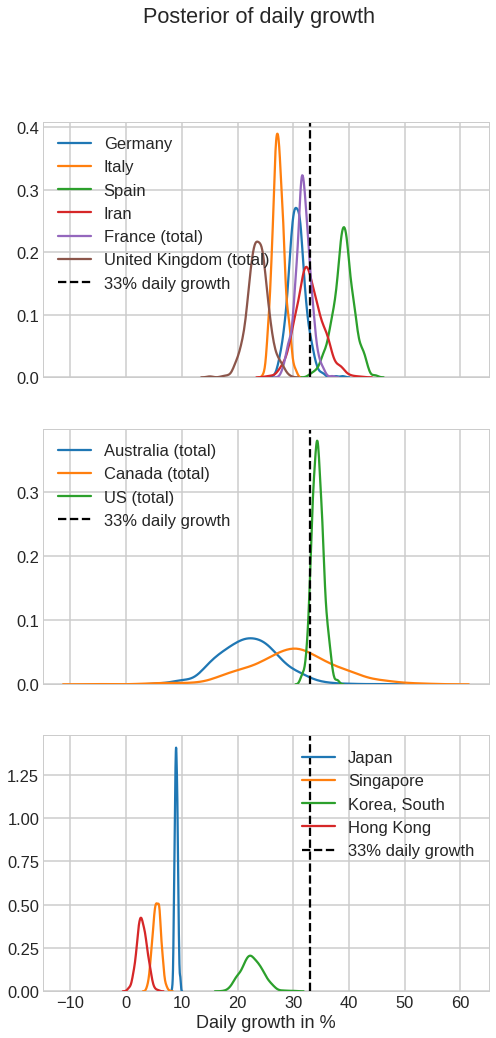

In [7]:
#hide_input
fig, axs = plt.subplots(nrows=len(country_groups), figsize=(8, 16), sharex=True)

for ax, country_group in zip(axs, country_groups):
    for i, country in enumerate(countries):
        if country in country_group:
            sns.distplot((trace['b_ind'][:, i] * 100) - 100, ax=ax, label=country, hist=False)
        
    ax.axvline(33, ls='--', color='k', label='33% daily growth')
    ax.legend()
ax.set_xlabel('Daily growth in %')
plt.suptitle('Posterior of daily growth')

## Predicted Cases By Country

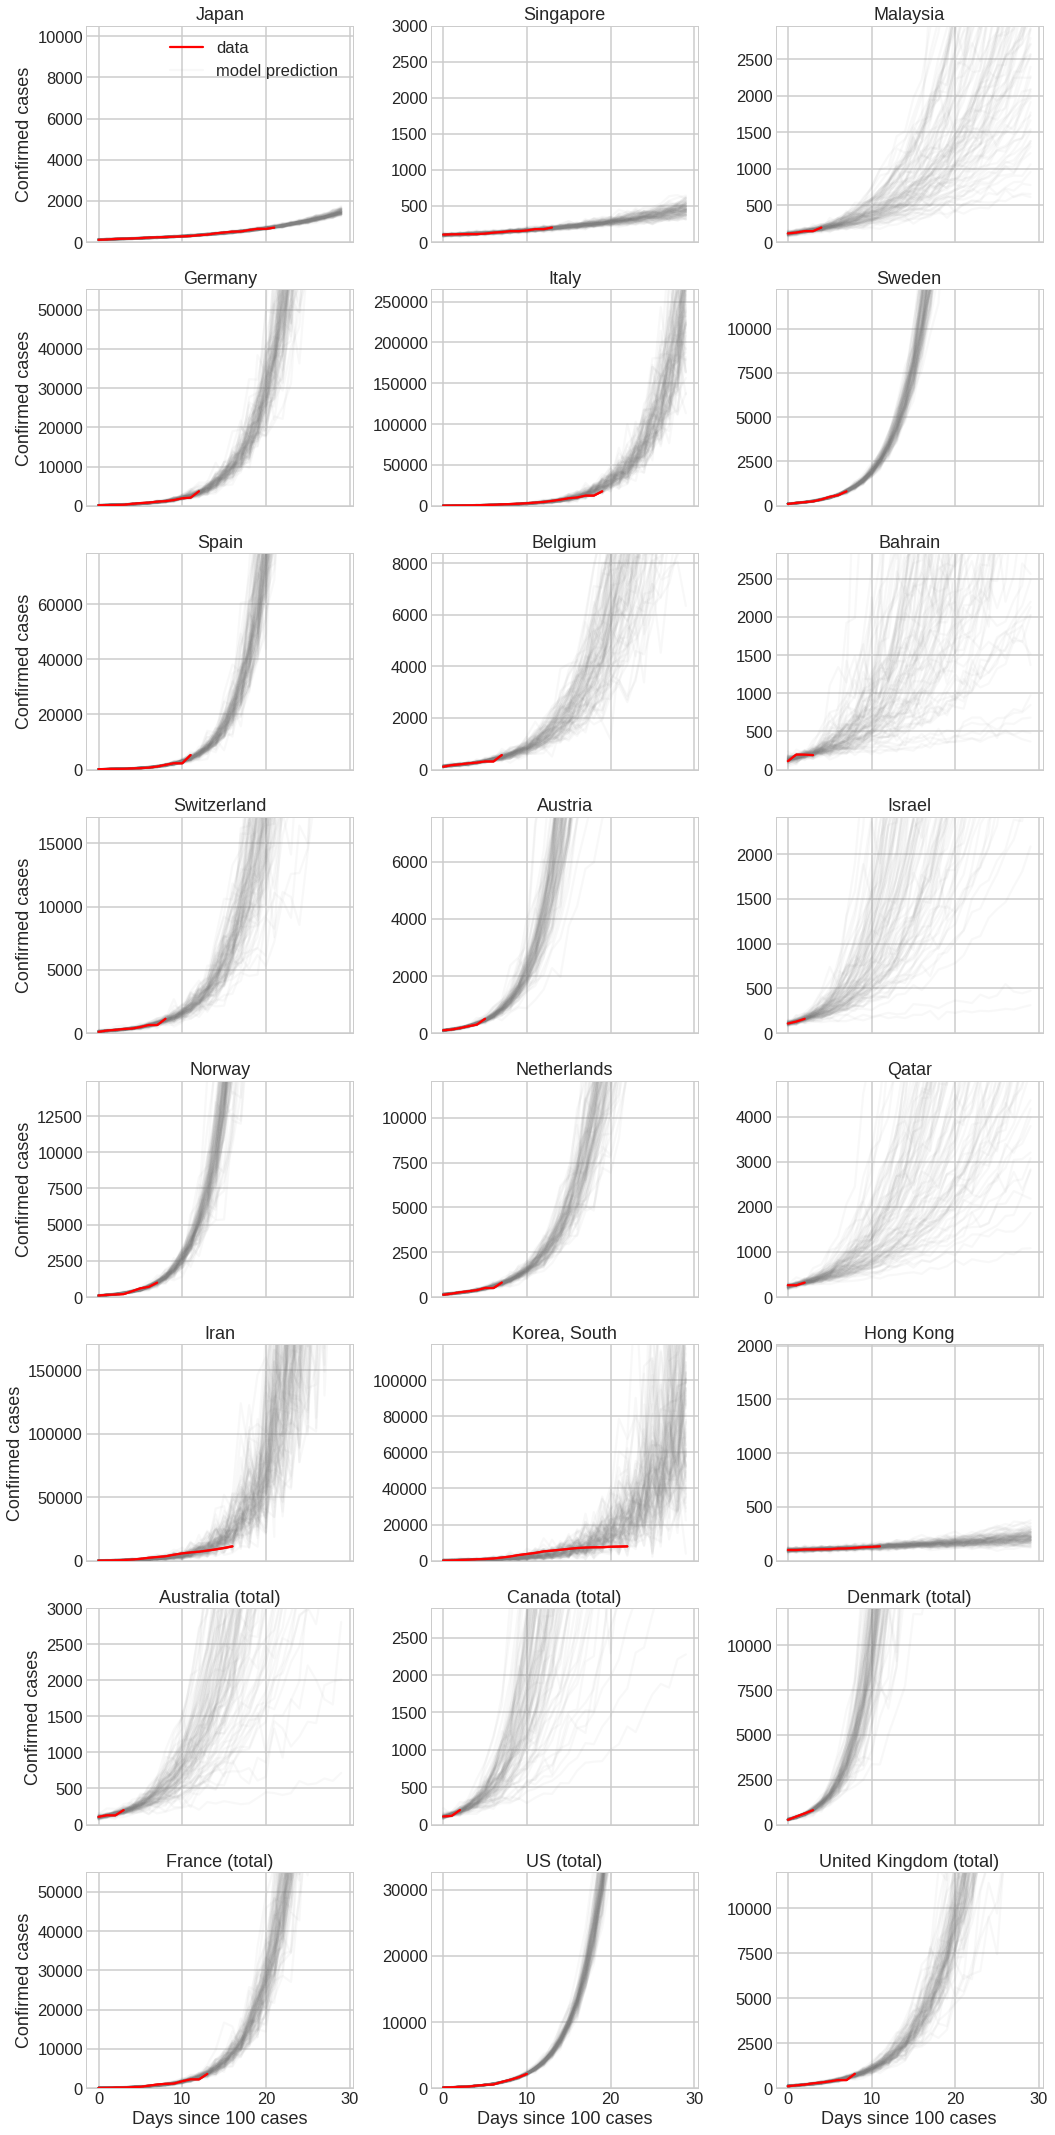

In [8]:
#hide_input
fig, axs = plt.subplots(nrows=n_countries // 3, ncols=3, figsize=(15, 30), sharex=True)

for ax, country in zip(axs.flatten(), countries):
    df_country = df_sign.loc[lambda x: x.country == country]
    ax.plot(df_country.days_since_100, df_country.cases, color='r')
    ax.plot(np.arange(0, post_pred[country].shape[1]), post_pred[country].T, alpha=.05, color='.5')
    ax.plot(df_country.days_since_100, df_country.cases, color='r')
    #ax.set_yscale('log')
    #ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_ylim(0, df_country.cases.iloc[-1] * 15)
    ax.set_title(country)
    
axs[0, 0].legend(['data', 'model prediction'])
[ax.set(xlabel='Days since 100 cases') for ax in axs[-1, :]]
[ax.set(ylabel='Confirmed cases') for ax in axs[:, 0]]
fig.tight_layout()

## Predicted Cases By Country - Log Scale

Y axis is on a log scale

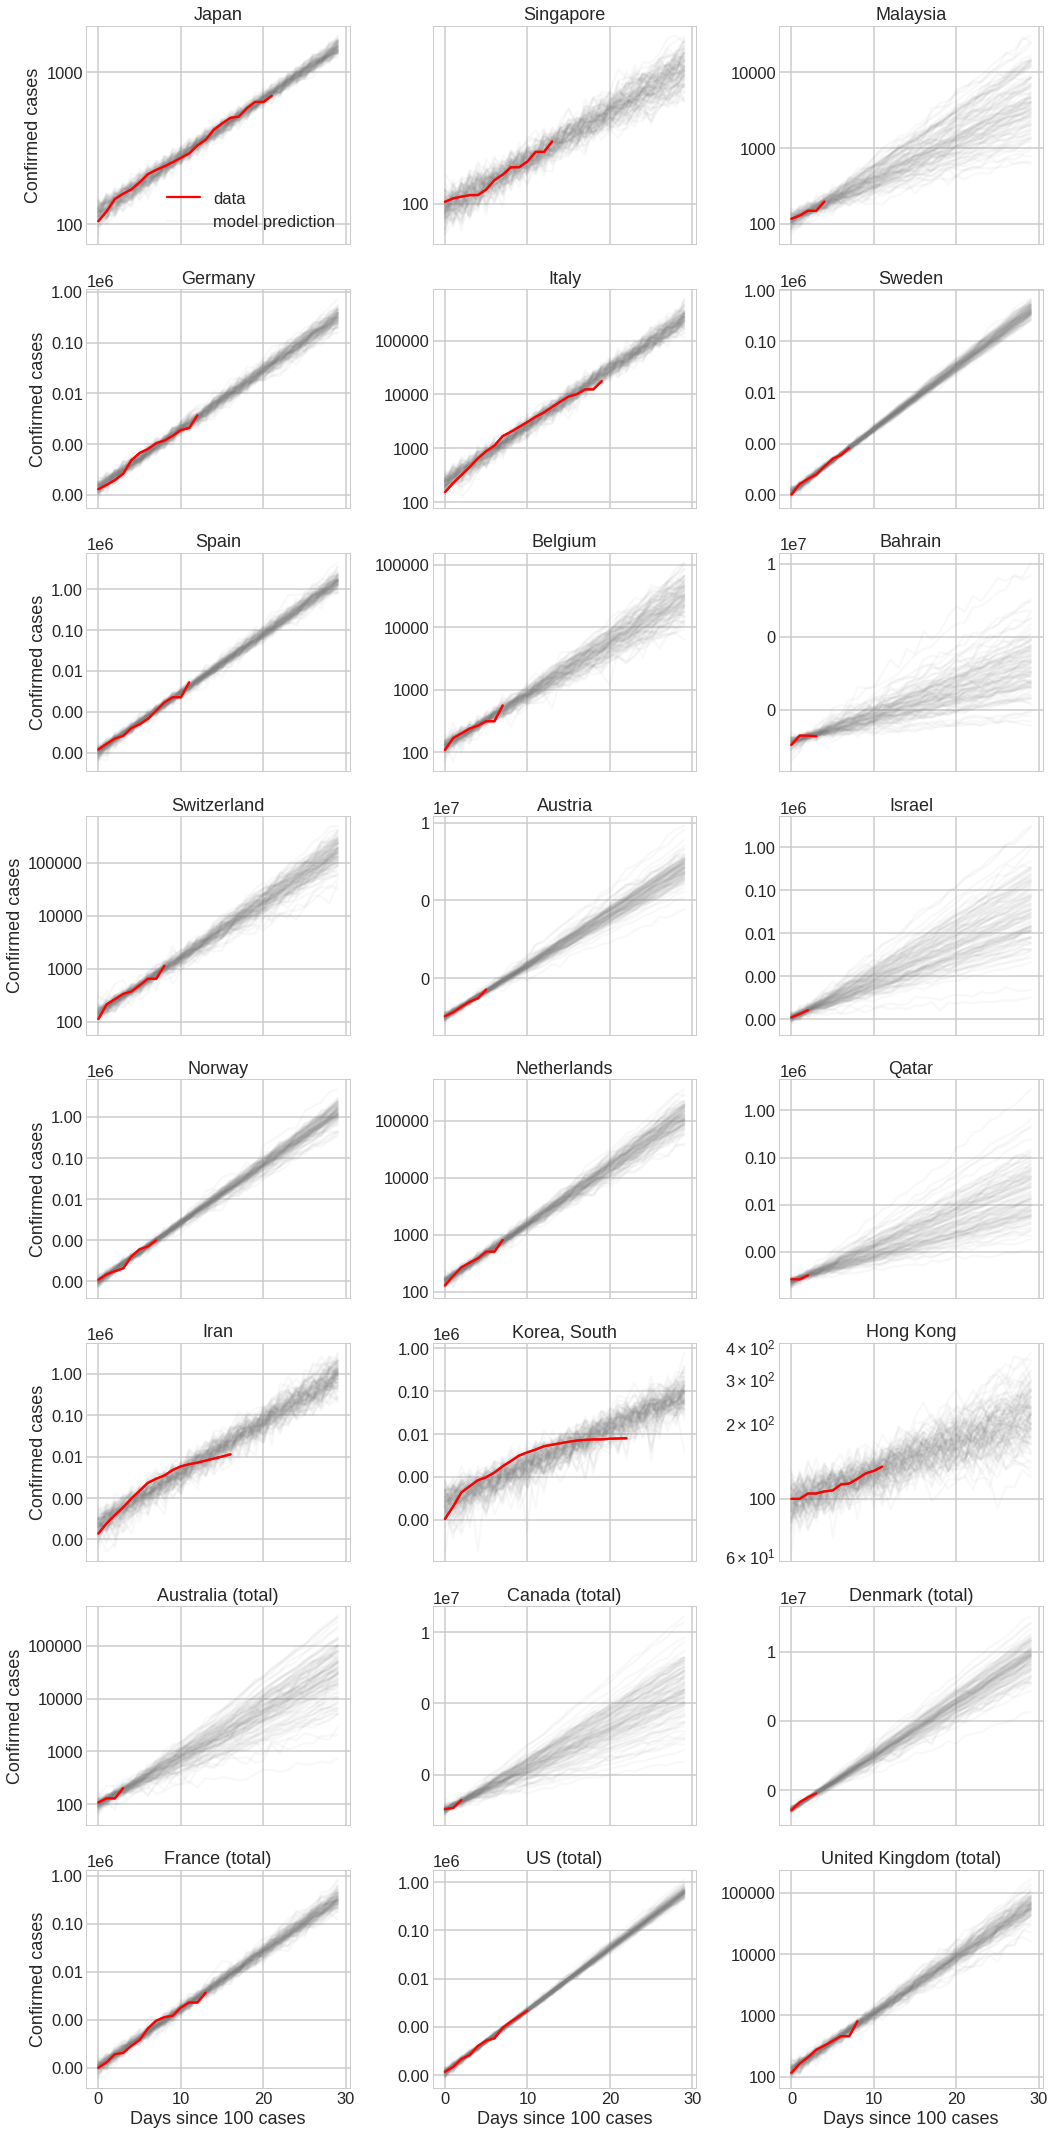

In [9]:
#hide_input
fig, axs = plt.subplots(nrows=n_countries // 3, ncols=3, figsize=(15, 30), sharex=True)

for ax, country in zip(axs.flatten(), countries):
    df_country = df_sign.loc[lambda x: x.country == country]
    ax.plot(df_country.days_since_100, df_country.cases, color='r')
    ax.plot(np.arange(0, post_pred[country].shape[1]), post_pred[country].T, alpha=.05, color='.5')
    ax.plot(df_country.days_since_100, df_country.cases, color='r')
    ax.set_yscale('log')
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #ax.set_ylim(0, df_country.cases.iloc[-1] * 2.5)
    ax.set_title(country)
    
axs[0, 0].legend(['data', 'model prediction'])
[ax.set(xlabel='Days since 100 cases') for ax in axs[-1, :]]
[ax.set(ylabel='Confirmed cases') for ax in axs[:, 0]]
fig.tight_layout()

## Model Diagnostics - Trace Plots

These are diagnostics for the model.  You can safely ignore this if not familiar with [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo).

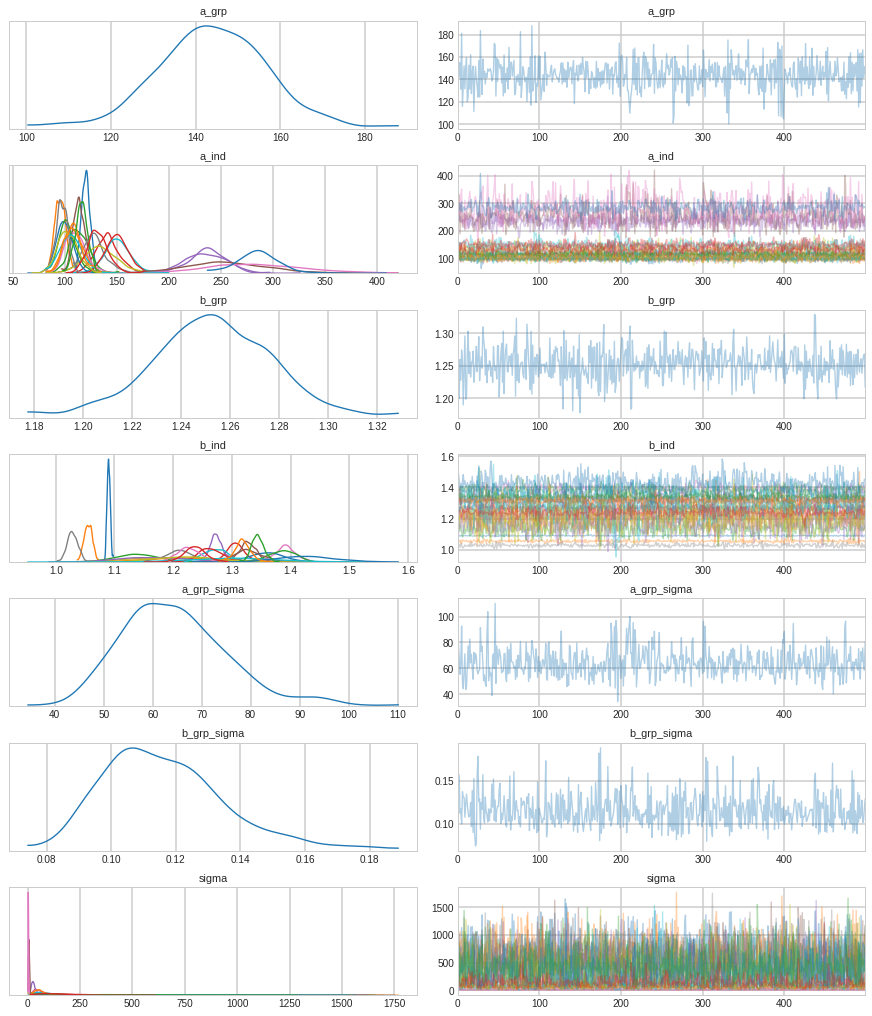

In [10]:
#hide_input
az.plot_trace(trace, compact=True);

# About This Analysis

This page was made by [Thomas Wiecki](https://twitter.com/twiecki)[^1]

The model that we are building assumes exponential growth. This is definitely wrong because growth would just continue uninterrupted into the future. However, in the early phase of an epidemic it's a reasonable assumption.

We assume a [negative binomial](https://docs.pymc.io/api/distributions/discrete.html#pymc3.distributions.discrete.NegativeBinomial) likelihood as we are dealing with count data. A Poisson could also be used but the negative binomial allows us to also model the variance separately to give more flexibility.

The model is also hierarchical, pooling information from individual countries.


[^1]:  This notebook gets up-to-date data from the ["2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE"](https://systems.jhu.edu/research/public-health/ncov/) [GitHub repository](https://github.com/CSSEGISandData/COVID-19). This code is provided under the [BSD-3 License](https://github.com/twiecki/covid19/blob/master/LICENSE). Link to [original notebook](https://github.com/twiecki/covid19/blob/master/covid19_growth_bayes.ipynb).